In [1]:
#!pip install FundamentalAnalysis

In [715]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import FundamentalAnalysis as fa
import datetime
import numpy as np
import datetime

tickers = ['AAPL','NFLX','AMZN','MSFT','NVDA','SPY']

start_date = '2016-01-01'
end_date = '2019-12-31'

df = data.DataReader(tickers,'yahoo', start_date, end_date)
df = df.stack().reset_index()

# The ratios could only be retrived for one company at a time using the free API Key from FinancialModellingPrep
AAPL_ratio =  fa.financial_ratios('AAPL', "b1954571c728b215d6fe4e5a75f51636", period="quarter")
NFLX_ratio =  fa.financial_ratios('NFLX', "b1954571c728b215d6fe4e5a75f51636", period="quarter")
AMZN_ratio =  fa.financial_ratios('AMZN', "b1954571c728b215d6fe4e5a75f51636", period="quarter")
MSFT_ratio =  fa.financial_ratios('MSFT', "b1954571c728b215d6fe4e5a75f51636", period="quarter")
NVDA_ratio =  fa.financial_ratios('NVDA', "b1954571c728b215d6fe4e5a75f51636", period="quarter")

# Save the quarterly ratios from 2015Q4 to 2019Q4 for further analysis
AAPL = AAPL_ratio.T.iloc[2:19][['currentRatio','quickRatio','debtEquityRatio', 'priceEarningsRatio']].reset_index()
NFLX = NFLX_ratio.T.iloc[2:19][['currentRatio','quickRatio','debtEquityRatio', 'priceEarningsRatio']].reset_index()
AMZN = AMZN_ratio.T.iloc[2:19][['currentRatio','quickRatio','debtEquityRatio', 'priceEarningsRatio']].reset_index()
MSFT = MSFT_ratio.T.iloc[2:19][['currentRatio','quickRatio','debtEquityRatio', 'priceEarningsRatio']].reset_index()
NVDA = NVDA_ratio.T.iloc[2:19][['currentRatio','quickRatio','debtEquityRatio', 'priceEarningsRatio']].reset_index()

AAPL['ticker'] = 'AAPL'
NFLX['ticker'] = 'NFLX'
AMZN['ticker'] = 'AMZN'
MSFT['ticker'] = 'MSFT'
NVDA['ticker'] = 'NVDA'

earn = pd.concat([AAPL,NFLX,AMZN,MSFT,NVDA], axis=0)
earn.reset_index(inplace=True, drop=True)
earn['yr'] = earn['index'].str[0:4].apply(int)
earn['month'] = earn['index'].str[-2:].apply(int)

qtr = {12:4, 9:3, 6:2, 7:2, 4:1, 10:3, 1:5, 3:1, 5:1}
earn['q'] = earn['month'].map(qtr)

def calc_earn(df):
    if df['q'] == 5:
        yr = df['yr'] - 1
        q = 1
    else:
        yr = df['yr']
        q = df['q']
    return str(yr) + 'Q' + str(q)

earn['quarter'] = earn.apply(calc_earn, axis=1)
#https://www.marketbeat.com/stocks/NASDAQ/AAPL/earnings/
earn_dates = pd.read_csv('earnings_dates.csv')

lenCheck = len(earn)
earn = earn.merge(earn_dates, how='left', on=['ticker','quarter'])
if lenCheck!= len(earn):
    raise Exception('merge error')
    
    
earn.dropna(inplace=True)
earn = earn[['currentRatio','quickRatio','debtEquityRatio', 'priceEarningsRatio','quarter','ticker','date']]
earn.rename(columns={'date':'Date','ticker':'Symbols'},inplace=True)
earn['Date'] = earn['Date'].apply(pd.Timestamp)
earn = earn[~earn.duplicated(['Symbols','Date'], keep='last')]

lenCheck = len(df)
df = df.merge(earn, how='left', on=['Date','Symbols'])
if lenCheck != len(df):
    raise Exception('merge error')
    
    
df.sort_values(['Symbols','Date'], ascending=[True,False], inplace=True)
df.reset_index(inplace=True, drop=True)

df['price_last_earn'] = np.where(pd.notnull(df['quarter']), df['Adj Close'], np.nan)

df[['currentRatio','quickRatio','debtEquityRatio', 'priceEarningsRatio','quarter','price_last_earn']] = df[['Symbols','currentRatio','quickRatio','debtEquityRatio', 'priceEarningsRatio','quarter','price_last_earn']].groupby('Symbols').fillna(method='bfill')

df['Date'] = df['Date'].apply(lambda x: x.date())


spy = df[df['Symbols']=='SPY'].copy()
df = df[df['Symbols']!='SPY']
spy.rename(columns={'Adj Close':'spy_price','Volume':'spy_volume'}, inplace=True)

lenCheck = len(df)
df = df.merge(spy[['spy_price','spy_volume','Date']], how='left', on=['Date'])
if lenCheck!=len(df):
    raise Exception('merge error')

df.rename(columns={'Adj Close':'price','Symbols':'ticker'}, inplace=True)                   
for period in [5,10,63,126]:
    df['price_{}'.format(period)] = df[['ticker','price']].groupby('ticker').rolling(period).mean().shift(-period+1).reset_index()['price']
    #df['open_{}'.format(period)] = df[['ticker','Open']].groupby('ticker').rolling(period).mean().shift(-period+1).reset_index()['Open']
    #df['close_{}'.format(period)] = df[['ticker','Close']].groupby('ticker').rolling(period).mean().shift(-period+1).reset_index()['Close']
    #df['high_{}'.format(period)] = df[['ticker','High']].groupby('ticker').rolling(period).mean().shift(-period+1).reset_index()['High']
    
df['prior'] = df[['ticker','price']].groupby('ticker').shift(-1).reset_index()['price']
df['spy_prior'] = df[['ticker','spy_price']].groupby('ticker').shift(-1).reset_index()['spy_price']

df['chg'] = df.apply(lambda x: np.log(x['price']/x['prior']), axis=1)
df['spy_chg'] = df.apply(lambda x: np.log(x['spy_price']/x['spy_prior']), axis=1)

df['chg2'] = df['chg']**2
df['spy_chg2'] = df['spy_chg']**2

for period in [5,10,63,126]:
    df['vol_{}'.format(period)] = (df[['ticker','chg2']].groupby('ticker').rolling(period).mean().shift(-period+1).reset_index()['chg2'] * 252 * np.pi / 2) ** 0.5 * 100
    df['spy_vol_{}'.format(period)] = (df[['ticker','spy_chg2']].groupby('ticker').rolling(period).mean().shift(-period+1).reset_index()['spy_chg2'] * 252 * np.pi / 2) ** 0.5 * 100
    

df['pe'] = df['price'] / df['price_last_earn'] * df['priceEarningsRatio']

df['next_day_price'] = df[['ticker','price']].groupby('ticker').shift(1)['price']
df['price_change_percent'] = np.log(df['next_day_price'] / df['price'])


#eliminate early dates that do not have full information (rolling averages)
df = df[df['Date']>=datetime.date(2017,1,1)]

#Split data into train (first 2 years of data), cross val (next 6 months), test (final 6 months)
df['IS'] = df['Date']<datetime.date(2019,1,1) #split train/test by time to exclude future unknown experience
df['IS'] = df['IS'].apply(int)
df['CV'] = (df['Date']>=datetime.date(2019,1,1))&(df['Date']<=datetime.date(2019,6,30)) #cross val
df['CV'] = df['CV'].apply(int)

# df.to_pickle('stock_data.pkl')
df.head(2)

Date ticker       price       Close        High         Low  \
0  2019-12-31   AAPL  291.638000  293.649994  293.679993  289.519989   
1  2019-12-30   AAPL  289.522614  291.519989  292.690002  285.220001   

         Open      Volume  currentRatio  quickRatio  debtEquityRatio  \
0  289.929993  25201400.0      1.540126    1.168041         2.741004   
1  289.459991  36028600.0      1.540126    1.168041         2.741004   

   priceEarningsRatio quarter  price_last_earn   spy_price  spy_volume  \
0           82.259199  2019Q3       240.870102  318.576508  57077300.0   
1           82.259199  2019Q3       240.870102  317.804443  49729100.0   

      price_5    price_10    price_63   price_126       prior   spy_prior  \
0  287.844183  283.321396  255.788481  231.500555  289.522614  317.804443   
1  285.927411  281.951843  254.689204  230.773098  287.814392  319.566284   

        chg   spy_chg      chg2  spy_chg2      vol_5  spy_vol_5     vol_10  \
0  0.007280  0.002426  0.000053  0.000006  19.392625   7.156975  17.252223   
1  0.005918 -0.005528  0.000035  0.000031  23.271068   6.957469  19.766019   

   spy_vol_10     vol_63  spy_vol_63    vol_126  spy_vol_126         pe  \
0    6.383810  23.989473   11.538432  29.008997    15.705504  99.596870   
1    7.548332  23.930004   11.906392  28.998750    15.706381  98.874447   

   next_day_price  price_change_percent  IS  CV  
0             NaN                   NaN   0   0  
1         291.638               0.00728   0   0

In [716]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import FundamentalAnalysis as fa
import datetime
import numpy as np
import datetime

# save the output file
df.to_csv(r'df.csv',index = False)

#df = pd.read_csv('df.csv')
df.head(2)

Date ticker       price       Close        High         Low  \
0  2019-12-31   AAPL  291.638000  293.649994  293.679993  289.519989   
1  2019-12-30   AAPL  289.522614  291.519989  292.690002  285.220001   

         Open      Volume  currentRatio  quickRatio  debtEquityRatio  \
0  289.929993  25201400.0      1.540126    1.168041         2.741004   
1  289.459991  36028600.0      1.540126    1.168041         2.741004   

   priceEarningsRatio quarter  price_last_earn   spy_price  spy_volume  \
0           82.259199  2019Q3       240.870102  318.576508  57077300.0   
1           82.259199  2019Q3       240.870102  317.804443  49729100.0   

      price_5    price_10    price_63   price_126       prior   spy_prior  \
0  287.844183  283.321396  255.788481  231.500555  289.522614  317.804443   
1  285.927411  281.951843  254.689204  230.773098  287.814392  319.566284   

        chg   spy_chg      chg2  spy_chg2      vol_5  spy_vol_5     vol_10  \
0  0.007280  0.002426  0.000053  0.000006  19.392625   7.156975  17.252223   
1  0.005918 -0.005528  0.000035  0.000031  23.271068   6.957469  19.766019   

   spy_vol_10     vol_63  spy_vol_63    vol_126  spy_vol_126         pe  \
0    6.383810  23.989473   11.538432  29.008997    15.705504  99.596870   
1    7.548332  23.930004   11.906392  28.998750    15.706381  98.874447   

   next_day_price  price_change_percent  IS  CV  
0             NaN                   NaN   0   0  
1         291.638               0.00728   0   0

In [717]:
# reverse the rows of dataset
df = df.iloc[::-1].reset_index(drop=True)

# to display all columns of dataframes
pd.set_option('display.max_columns', None)

df.head(2)

Date ticker       price       Close        High         Low  \
0  2017-01-03   NVDA  100.830811  102.010002  106.370003   99.379997   
1  2017-01-04   NVDA  103.183281  104.389999  105.500000  101.529999   

         Open      Volume  currentRatio  quickRatio  debtEquityRatio  \
0  104.400002  37549900.0      4.070064    3.676629         0.805409   
1  103.400002  29980500.0      4.070064    3.676629         0.805409   

   priceEarningsRatio quarter  price_last_earn   spy_price  spy_volume  \
0          112.347325  2016Q3        66.886467  210.625656  91366500.0   
1          112.347325  2016Q3        66.886467  211.878738  78744400.0   

      price_5    price_10   price_63  price_126       prior   spy_prior  \
0  108.085962  106.382879  83.094991  70.931584  105.506119  209.026611   
1  105.529852  106.655686  83.662828  71.377941  100.830811  210.625656   

        chg   spy_chg      chg2  spy_chg2       vol_5  spy_vol_5     vol_10  \
0 -0.045325  0.007621  0.002054  0.000058  104.467606  10.771166  79.317162   
1  0.023063  0.005932  0.000532  0.000035   88.550889  11.790354  80.274678   

   spy_vol_10     vol_63  spy_vol_63    vol_126  spy_vol_126          pe  \
0    8.417508  83.674146   10.890569  64.223407    11.474784  169.362688   
1    9.105475  83.871809   10.916692  64.343630    11.473998  173.314066   

   next_day_price  price_change_percent  IS  CV  
0      103.183281              0.023063   1   0  
1      100.563942             -0.025713   1   0

## EDA

In [718]:
tickers_ = ["AMZN","AAPL","NVDA","MSFT","NFLX"]

df9 = pd.DataFrame() 

for i in tickers_:
    a = df[df["ticker"]==i]
    b = a.describe()[["next_day_price"]]
    b.rename(columns = {'next_day_price': i}, inplace = True)
    df9 = pd.concat([df9, b], axis=1)
df9
    

# aapl = df[df["ticker"]=="AAPL"]
# aapl.describe()[["price"]]

#df.iloc[:,1:3].describe()

AMZN        AAPL        NVDA        MSFT        NFLX
count   753.000000  753.000000  753.000000  753.000000  753.000000
mean   1467.735989  177.947815  184.547303   98.428052  271.446427
std     384.049796   35.507210   47.973155   26.755742   83.308845
min     757.179993  110.070328   94.505310   58.563644  129.179993
25%    1003.739990  151.003662  151.029373   72.012451  185.729996
50%    1607.949951  170.954300  179.418243   98.241867  291.570007
75%    1787.829956  200.754089  223.920639  117.190964  346.709991
max    2039.510010  291.638000  287.642822  157.705505  418.970001

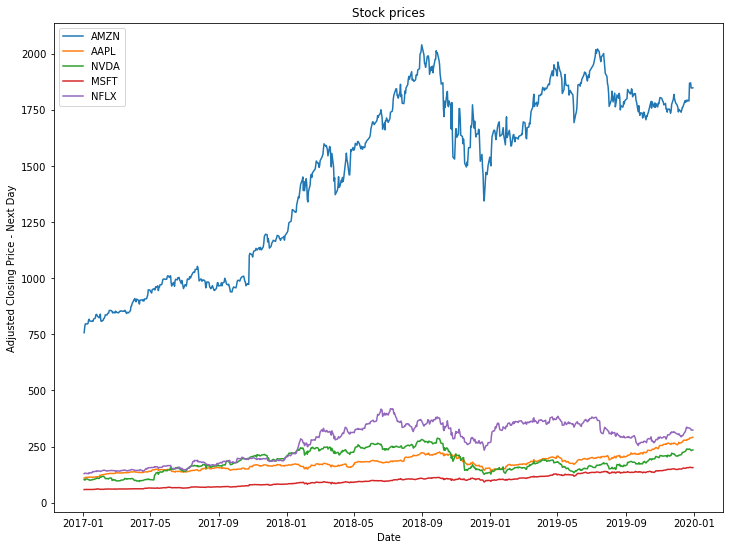

In [298]:
tickers_ = ["AMZN","AAPL","NVDA","MSFT","NFLX"]

df9 = pd.DataFrame() 


plt.figure(figsize=(12,9))
    
for i in tickers_:
    a = df[df["ticker"]==i]
    b = a[["Date","next_day_price"]]
    plt.plot(a["Date"],a["next_day_price"])
    #b.rename(columns = {'price': i}, inplace = True)
    #df9 = pd.concat([df9, b], axis=1)
    
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price - Next Day')
plt.title('Stock prices')
plt.legend(tickers_)
plt.show()


### Correlation Matrix

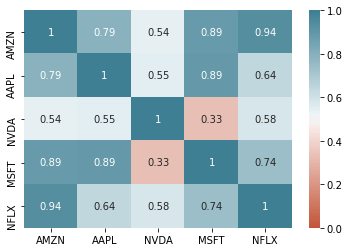

AMZN      AAPL      NVDA      MSFT      NFLX
AMZN  1.000000  0.793210  0.542251  0.888051  0.936622
AAPL  0.793210  1.000000  0.554919  0.894701  0.640721
NVDA  0.542251  0.554919  1.000000  0.334876  0.583692
MSFT  0.888051  0.894701  0.334876  1.000000  0.743694
NFLX  0.936622  0.640721  0.583692  0.743694  1.000000

In [296]:
tickers_ = ["AMZN","AAPL","NVDA","MSFT","NFLX"]

df9 = pd.DataFrame() 

for i in tickers_:
    a = df[df["ticker"]==i]
    b = a[["next_day_price"]].reset_index(drop=True)
    b.rename(columns = {'next_day_price': i}, inplace = True)
    df9 = pd.concat([df9, b], axis=1)
corr = df9.corr()

#import pandas.rpy.common as com
import seaborn as sns
%matplotlib inline


# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True,
        vmin=0,
        cmap=sns.diverging_palette(20, 220, n=200))
plt.show()
corr

### EDA - Pairplot

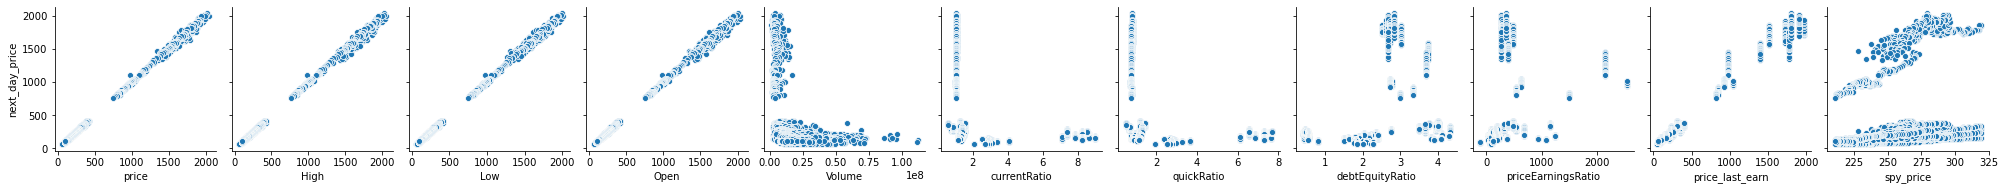

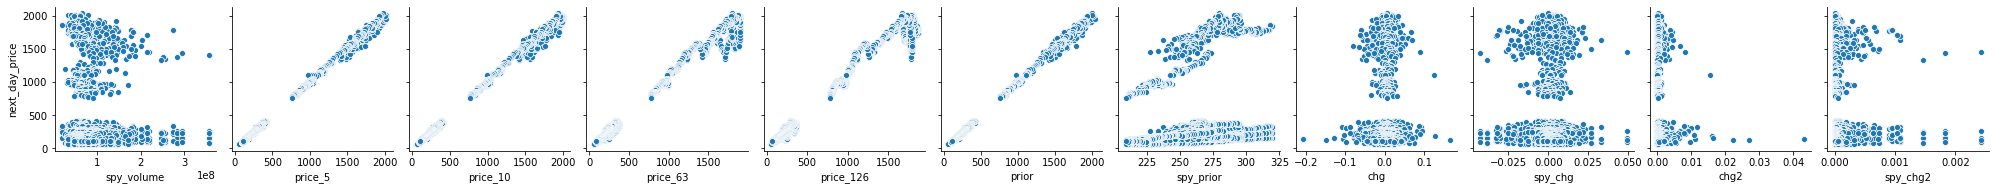

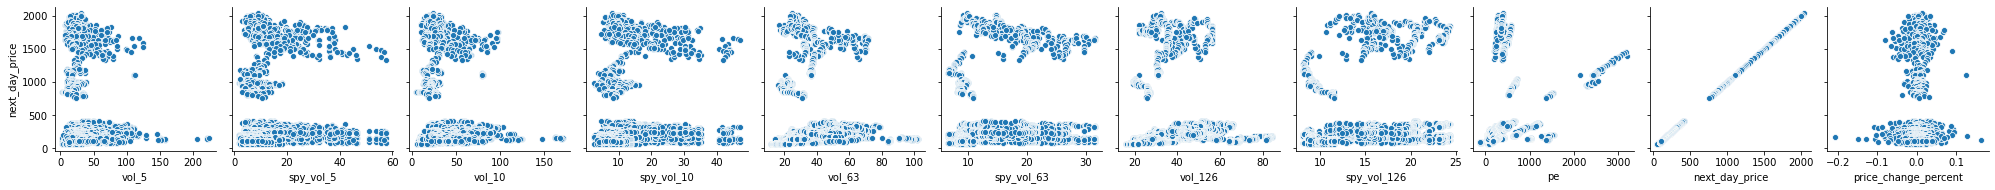

In [629]:
df_target = df[["next_day_price"]]
df_explanatory = df.drop(["quarter","IS","CV","Close","Date","ticker"],axis=1)
df_explanatory

for i in range(0, len(df_explanatory.columns),11):
    sns.pairplot(data=df_explanatory,
    x_vars=df_explanatory.columns[i:i+11],
    y_vars=["next_day_price"])

plt.show()

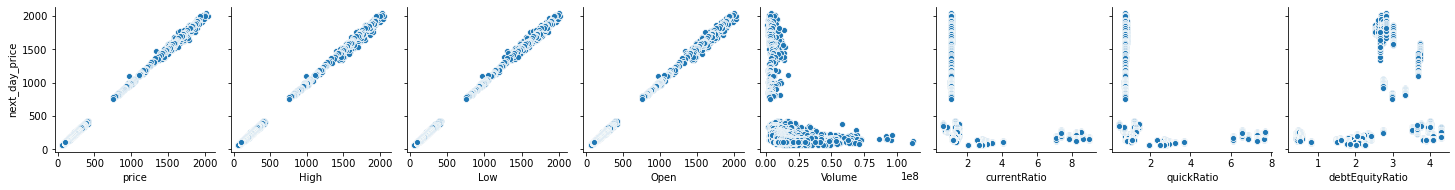

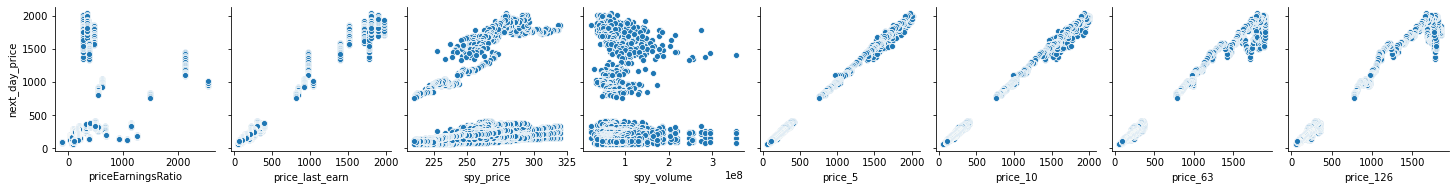

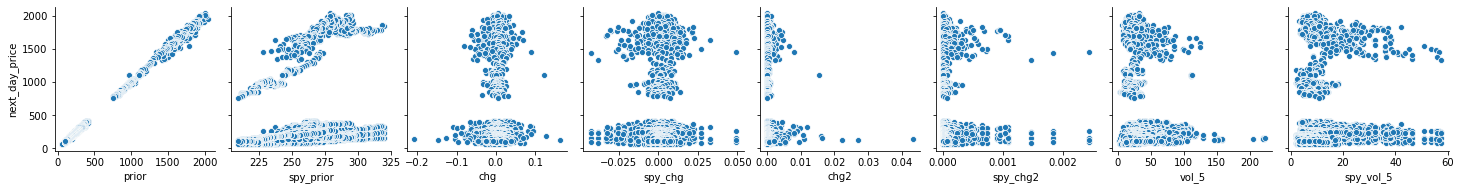

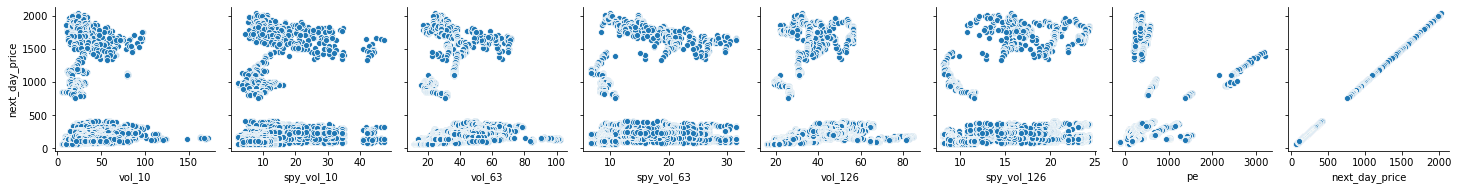

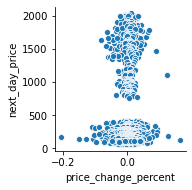

In [627]:
df_target = df[["next_day_price"]]
df_explanatory = df.drop(["quarter","IS","CV","Close","Date","ticker"],axis=1)
df_explanatory

for i in range(0, len(df_explanatory.columns),8):
    sns.pairplot(data=df_explanatory,
    x_vars=df_explanatory.columns[i:i+8],
    y_vars=["next_day_price"])

plt.show()

# Data modeling

In [719]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as cv
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [720]:
# load the sentiment dataset

amazon = pd.read_csv("amazon.csv")
amazon.drop("Unnamed: 0",axis=1,inplace=True)
amazon["ticker"] = "AMZN"

apple = pd.read_csv("apple.csv")
apple.drop("Unnamed: 0",axis=1,inplace=True)
apple["ticker"] = "AAPL"

nvidia = pd.read_csv("nvidia.csv")
nvidia.drop("Unnamed: 0",axis=1,inplace=True)
nvidia["ticker"] = "NVDA"

microsoft = pd.read_csv("microsoft.csv")
microsoft.drop("Unnamed: 0",axis=1,inplace=True)
microsoft["ticker"] = "MSFT"

netflix = pd.read_csv("netflix.csv")
netflix.drop("Unnamed: 0",axis=1,inplace=True)
netflix["ticker"] = "NFLX"

sentiment_scores = pd.concat([apple,amazon,microsoft,netflix,nvidia],axis=0)
sentiment_scores

Date  Sentiment ticker
0     2017-01-01   0.429570   AAPL
1     2017-01-02   0.304455   AAPL
2     2017-01-03   0.291298   AAPL
3     2017-01-04   0.352015   AAPL
4     2017-01-05   0.211368   AAPL
...          ...        ...    ...
1088  2019-12-25   0.500016   NVDA
1089  2019-12-26   0.566800   NVDA
1090  2019-12-27   0.317359   NVDA
1091  2019-12-28   0.477624   NVDA
1092  2019-12-29   0.490947   NVDA

[5465 rows x 3 columns]

In [721]:
df = old_df

In [723]:
# create the baseline df
df_base = df.iloc[:,0:8]
df_base["next_day_price"] = df["next_day_price"]
df_base[["IS","CV"]] = df[["IS","CV"]]
df1=pd.get_dummies(df_base["ticker"],prefix="ticker")
df_base = pd.concat([df_base, df1], axis=1)
df_base.drop(["ticker","Close"],axis=1,inplace=True)

# create df with all the financial factors
df_with_fin = df.drop(["Close","quarter"],axis=1)
df1=pd.get_dummies(df_with_fin["ticker"],prefix="ticker")
df_with_fin = pd.concat([df_with_fin, df1], axis=1)
df_with_fin.drop(["ticker"],axis=1,inplace=True)

# create df with sentiment data
df5 = pd.read_csv('df.csv')
df5 = df5.iloc[::-1].reset_index(drop=True)
df_with_sentiment = pd.merge(df5, sentiment_scores, on=['Date', 'ticker'])
df1=pd.get_dummies(df_with_sentiment["ticker"],prefix="ticker")
df_with_sentiment = pd.concat([df_with_sentiment, df1], axis=1)
df_with_sentiment["senti"] = np.where(df_with_sentiment['Sentiment']<=0.5, 'positive', 'negative')
df1=pd.get_dummies(df_with_sentiment["senti"],prefix="sentiment")
df_with_sentiment = pd.concat([df_with_sentiment, df1], axis=1)
df_with_sentiment.drop(["ticker","Close","quarter","Sentiment","sentiment_negative","senti"],axis=1,inplace=True)

# APPLYING DECISIONTREE REGRESSION

# Baseline Model

In [724]:
# #eliminate early dates that do not have full information (rolling averages)
# df = df[df['Date']>=datetime.date(2017,1,1)]

# #Split data into train (first 2 years of data), cross val (next 6 months), test (final 6 months)
# df['IS'] = df['Date']<datetime.date(2019,1,1) #split train/test by time to exclude future unknown experience
# df['IS'] = df['IS'].apply(int)
# df['CV'] = (df['Date']>=datetime.date(2019,1,1))&(df['Date']<=datetime.date(2019,6,30)) #cross val
# df['CV'] = df['CV'].apply(int)

#old_df = df

df = df_base

#df_with_fin
#df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

In [725]:
# sentiment_scores[(sentiment_scores['Date']=="2019-01-01")&(sentiment_scores['ticker']=="AAPL")]

In [726]:
# remove unnecessary columns

train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]

In [727]:
print(len(X_train))
print(len(y_train))
print(len(X_cv))
print(len(y_cv))
print(len(X_test))
print(len(y_test))

2510
2510
620
620
640
640


Train set RMSE of DecisionTreeRegressor: 72.1830

Train set r^2 score: 0.9782

Validation set RMSE of DecisionTreeRegressor: 77.9916

Validation set r^2 score: 0.9849

20-fold CV RMSE of DecisionTreeRegressor: 65.9646


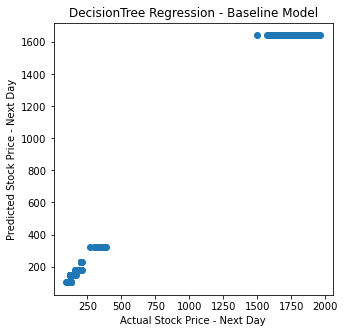

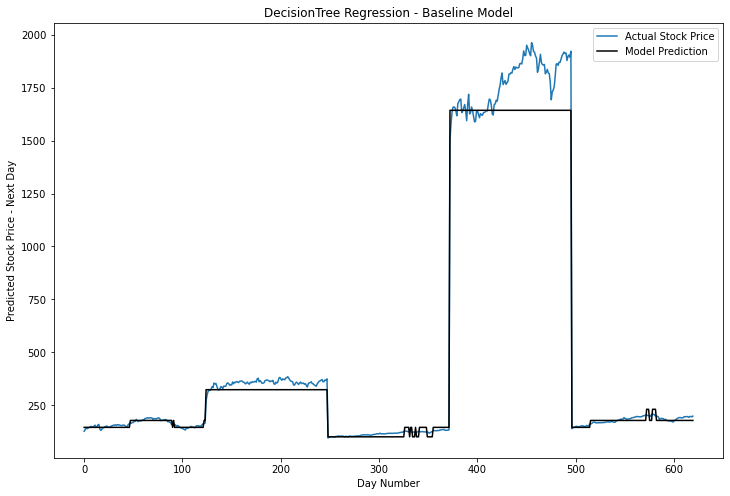

In [728]:
# Instantiate dt
dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.1, random_state=1)
# Fit dt to the training set
dt.fit(X_train, y_train)
# Predict the labels of the training set
y_pred_train = dt.predict(X_train)
# Evaluate the training set RMSE of dt
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)
# Print RMSE_train
print('Train set RMSE of DecisionTreeRegressor: {:.4f}'.format(RMSE_train))
print("\nTrain set r^2 score: {:.4f}".format(r2_score(y_train, y_pred_train)))

# Predict the labels of the training set
y_pred_cv = dt.predict(X_cv)
# Evaluate the CV set RMSE of dt
RMSE_CV = (MSE(y_cv, y_pred_cv))**(1/2)
# Print RMSE_train
print('\nValidation set RMSE of DecisionTreeRegressor: {:.4f}'.format(RMSE_CV))
print("\nValidation set r^2 score: {:.4f}".format(r2_score(y_cv, y_pred_cv)))

# Compute the array containing the 20-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, X_cv, y_cv, cv=20, scoring='neg_mean_squared_error', n_jobs=-1) 
# Compute the 20-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
# Print RMSE_CV
print('\n20-fold CV RMSE of DecisionTreeRegressor: {:.4f}'.format(RMSE_CV))

## Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_cv, y_pred_cv)
plt.xlabel('Actual Stock Price - Next Day')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('DecisionTree Regression - Baseline Model')
plt.show()

X = [x for x in range(len(y_cv))]
plt.figure(figsize=(12,8))
plt.plot(X,y_cv)
plt.plot(X,y_pred_cv,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('DecisionTree Regression - Baseline Model')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

## Model with financial data

In [730]:
#df = df_base
df = df_with_fin
#df = df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

# remove unnecessary columns
train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]

Train set RMSE of DecisionTreeRegressor: 72.1434

Train set r^2 score: 0.9782

Validation set RMSE of DecisionTreeRegressor: 77.9753

Validation set r^2 score: 0.9849

20-fold CV RMSE of DecisionTreeRegressor: 65.8742


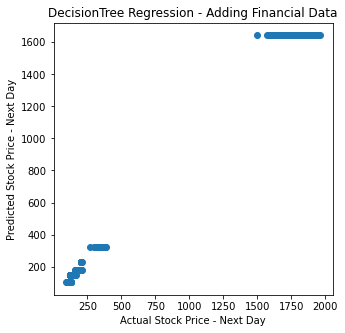

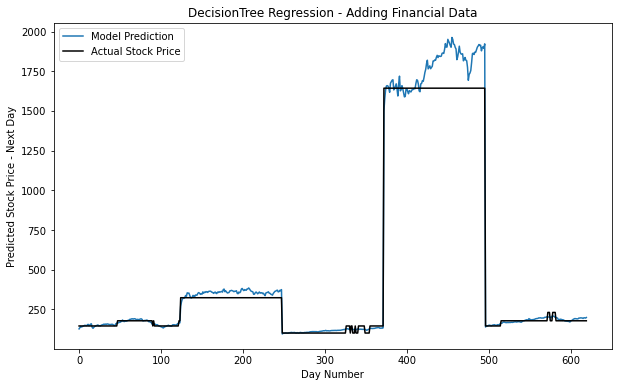

In [731]:
# Instantiate dt
dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.1, random_state=1)
# Fit dt to the training set
dt.fit(X_train, y_train)
# Predict the labels of the training set
y_pred_train = dt.predict(X_train)
# Evaluate the training set RMSE of dt
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)
# Print RMSE_train
print('Train set RMSE of DecisionTreeRegressor: {:.4f}'.format(RMSE_train))
print("\nTrain set r^2 score: {:.4f}".format(r2_score(y_train, y_pred_train)))

# Predict the labels of the training set
y_pred_cv2 = dt.predict(X_cv)
# Evaluate the CV set RMSE of dt
RMSE_CV = (MSE(y_cv, y_pred_cv2))**(1/2)
# Print RMSE_train
print('\nValidation set RMSE of DecisionTreeRegressor: {:.4f}'.format(RMSE_CV))
print("\nValidation set r^2 score: {:.4f}".format(r2_score(y_cv, y_pred_cv2)))

# Compute the array containing the 20-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, X_cv, y_cv, cv=20, scoring='neg_mean_squared_error', n_jobs=-1) 
# Compute the 20-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
# Print RMSE_CV
print('\n20-fold CV RMSE of DecisionTreeRegressor: {:.4f}'.format(RMSE_CV))

## Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_cv, y_pred_cv2)
plt.xlabel('Actual Stock Price - Next Day')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('DecisionTree Regression - Adding Financial Data')
plt.show()

X = [x for x in range(len(y_cv))]
plt.figure(figsize=(10,6))
plt.plot(X,y_cv)
plt.plot(X,y_pred_cv2,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('DecisionTree Regression - Adding Financial Data')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

## Model with sentiment dataset

In [732]:
#df = df_base
#df = df_with_fin
df = df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

# remove unnecessary columns
train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]

Train set RMSE of DecisionTreeRegressor: 72.1434

Train set r^2 score: 0.9782

Validation set RMSE of DecisionTreeRegressor: 77.9753

Validation set r^2 score: 0.9849

20-fold CV RMSE of DecisionTreeRegressor: 66.1376


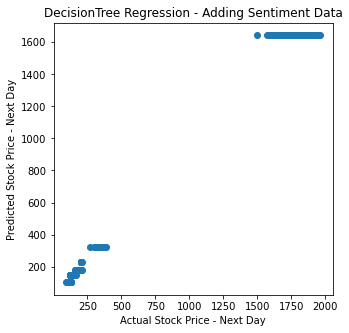

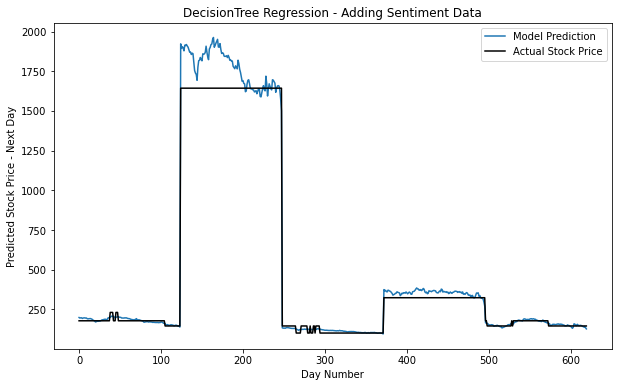

In [700]:
# Instantiate dt
dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.1, random_state=1)
# Fit dt to the training set
dt.fit(X_train, y_train)
# Predict the labels of the training set
y_pred_train = dt.predict(X_train)
# Evaluate the training set RMSE of dt
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)
# Print RMSE_train
print('Train set RMSE of DecisionTreeRegressor: {:.4f}'.format(RMSE_train))
print("\nTrain set r^2 score: {:.4f}".format(r2_score(y_train, y_pred_train)))

# Predict the labels of the training set
y_pred_cv3 = dt.predict(X_cv)
y_pred_dt = y_pred_cv3
# Evaluate the CV set RMSE of dt
RMSE_CV = (MSE(y_cv, y_pred_cv3))**(1/2)
# Print RMSE_train
print('\nValidation set RMSE of DecisionTreeRegressor: {:.4f}'.format(RMSE_CV))
print("\nValidation set r^2 score: {:.4f}".format(r2_score(y_cv, y_pred_cv3)))

# Compute the array containing the 20-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, X_cv, y_cv, cv=20, scoring='neg_mean_squared_error', n_jobs=-1) 
# Compute the 20-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
# Print RMSE_CV
print('\n20-fold CV RMSE of DecisionTreeRegressor: {:.4f}'.format(RMSE_CV))

## Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_cv, y_pred_cv3)
plt.xlabel('Actual Stock Price - Next Day')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('DecisionTree Regression - Adding Sentiment Data')
plt.show()

X = [x for x in range(len(y_cv))]
plt.figure(figsize=(10,6))
plt.plot(X,y_cv)
plt.plot(X,y_pred_cv3,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('DecisionTree Regression - Adding Sentiment Data')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

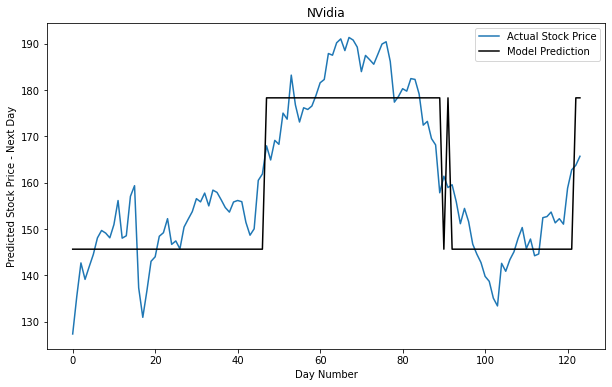

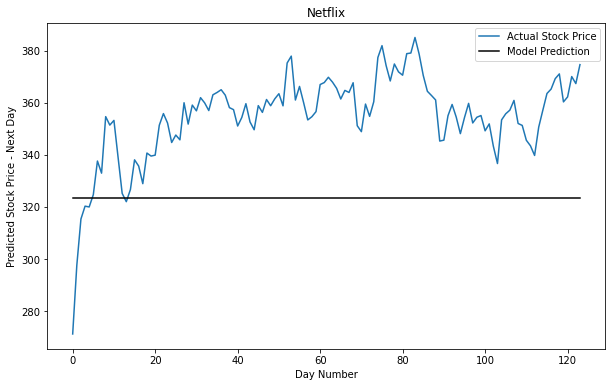

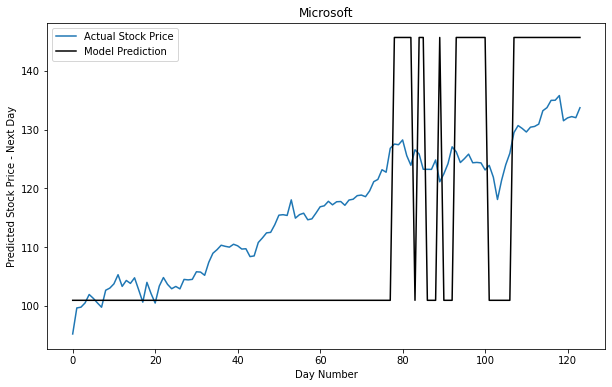

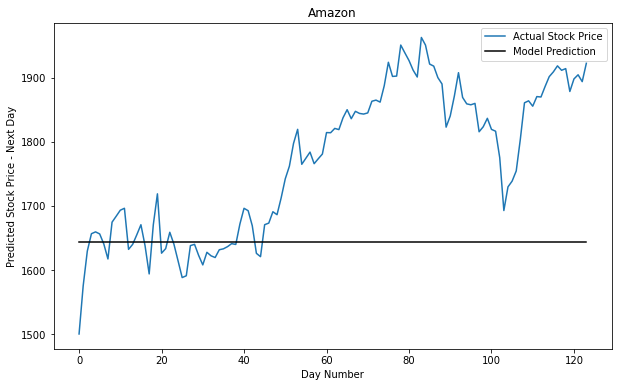

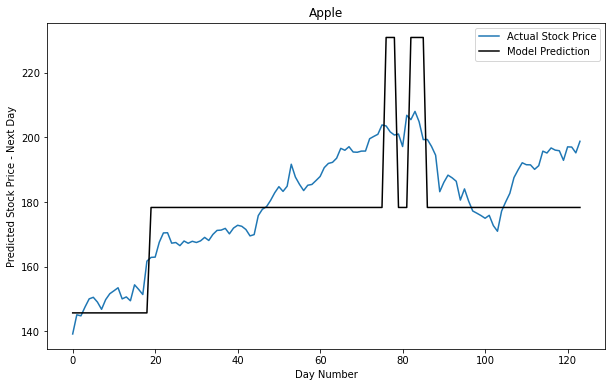

In [733]:
#X_cv[0:124]          NVDA
#X_cv[124:248]       NFLX
#X_cv[248:372]      MSFT
#X_cv[372:496]       AMZN
#X_cv[496:]       AAPL

X = [x for x in range(len(y_cv[0:124]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[0:124])
plt.plot(X,y_pred_cv[0:124],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('NVidia')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[124:248]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[124:248])
plt.plot(X,y_pred_cv[124:248],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Netflix')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[248:372]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[248:372])
plt.plot(X,y_pred_cv[248:372],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Microsoft')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()


#########

X = [x for x in range(len(y_cv[372:496]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[372:496])
plt.plot(X,y_pred_cv[372:496],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Amazon')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[496:]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[496:])
plt.plot(X,y_pred_cv[496:],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Apple')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

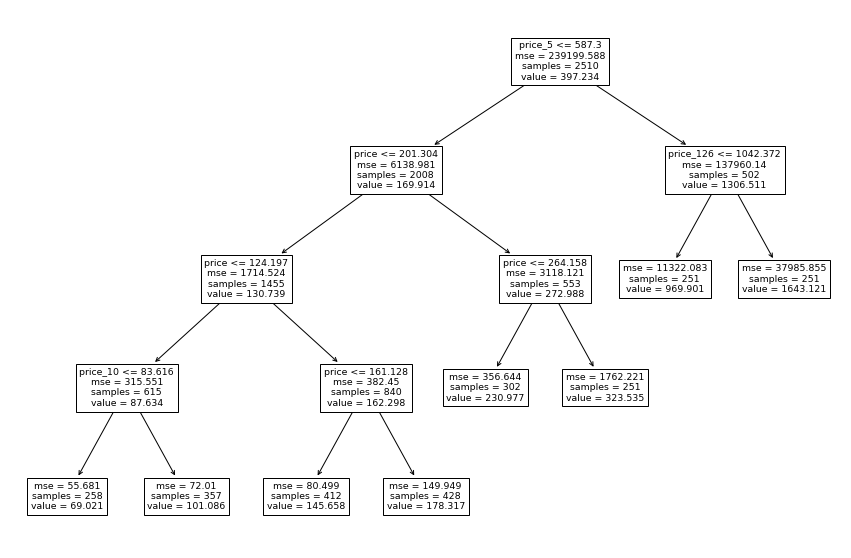

In [701]:
from sklearn import tree

plt.figure(figsize=(15,10))
plot = tree.plot_tree(dt,feature_names = X_cv.columns )

# APPLYING RANDOM FORESTS REGRESSION

## Baseline

Train set RMSE of RandomForest: 168.3441

Train set r^2 score: 0.8815

Validation set RMSE of RandomForest: 216.2677

Validation set r^2 score: 0.8835

20-fold CV RMSE of RandomForest: 67.8788


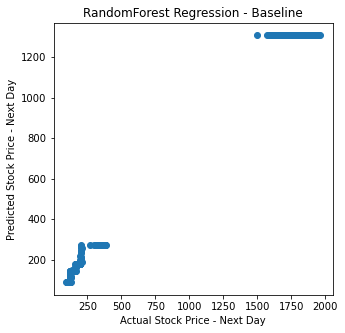

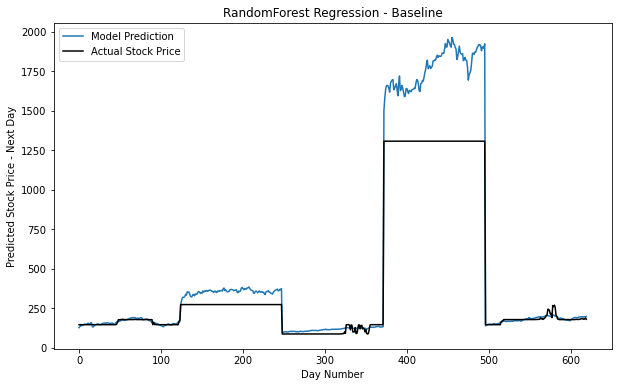

In [734]:
df = df_base
#df = df_with_fin
#df = df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

# remove unnecessary columns
train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]

# Instantiate a random forests regressor 'rf' 
rf = RandomForestRegressor(n_estimators=500,min_samples_leaf=0.1,random_state=3)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)
y_pred_train=rf.predict(X_train)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
print('Train set RMSE of RandomForest: {:.4f}'.format(rmse_train))
print("\nTrain set r^2 score: {:.4f}".format(r2_score(y_train, y_pred_train)))

# rmse for CV dataset
y_pred_cv=rf.predict(X_cv)
rmse_cv = MSE(y_cv, y_pred_cv)**(1/2)
print('\nValidation set RMSE of RandomForest: {:.4f}'.format(rmse_cv))
print("\nValidation set r^2 score: {:.4f}".format(r2_score(y_cv, y_pred_cv)))

# # Predict the test set labels 'y_pred'
# y_pred = rf.predict(X_test)
# # Evaluate the test set RMSE
# rmse_test = MSE(y_test, y_pred)**(1/2)
# # Print the test set RMSE
# print('Test set RMSE of RandomForest: {:.4f}'.format(rmse_test))

# Compute the array containing the 20-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, X_cv, y_cv, cv=20, scoring='neg_mean_squared_error', n_jobs=-1) 
# Compute the 20-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
# Print RMSE_CV
print('\n20-fold CV RMSE of RandomForest: {:.4f}'.format(RMSE_CV))

## Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_cv, y_pred_cv)
plt.xlabel('Actual Stock Price - Next Day')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('RandomForest Regression - Baseline')
plt.show()

X = [x for x in range(len(y_cv))]
plt.figure(figsize=(10,6))
plt.plot(X,y_cv)
plt.plot(X,y_pred_cv,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('RandomForest Regression - Baseline')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

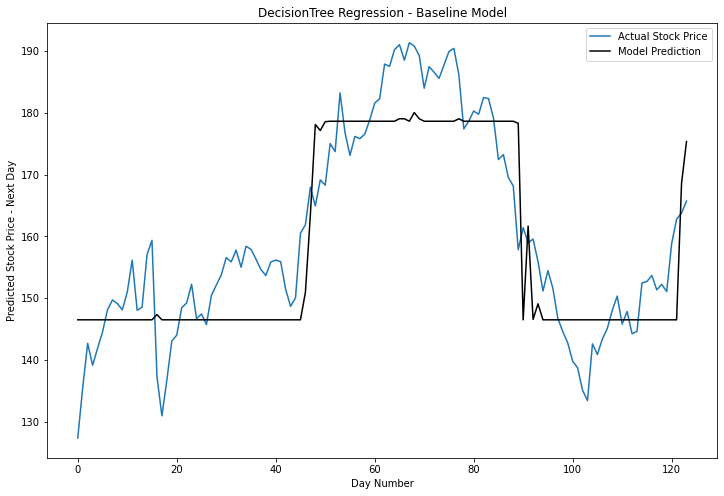

In [735]:
#X_cv[0:124]
#X_cv[124:248]
#X_cv[248:372]
#X_cv[372:496]
#X_cv[496:]

X = [x for x in range(len(y_cv[0:124]))]

plt.figure(figsize=(12,8))
plt.plot(X,y_cv[0:124])
plt.plot(X,y_pred_cv[0:124],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('DecisionTree Regression - Baseline Model')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

## With financial factors

Train set RMSE of RandomForest: 168.3430

Train set r^2 score: 0.8815

Validation set RMSE of RandomForest: 215.0588

Validation set r^2 score: 0.8848

20-fold CV RMSE of RandomForest: 67.3456


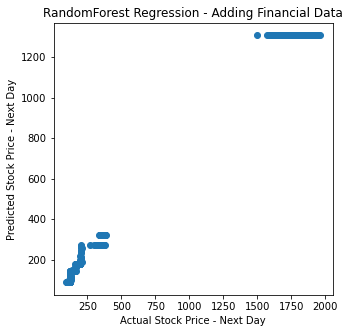

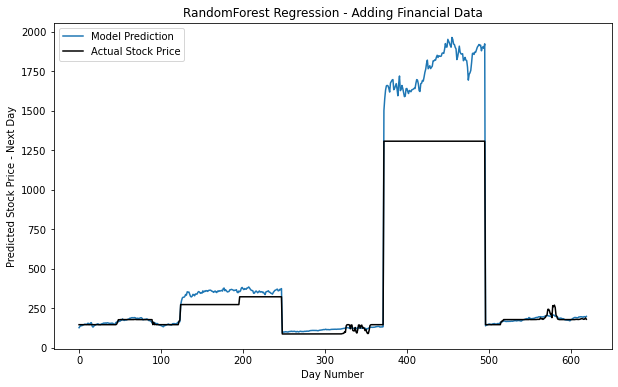

In [736]:
#df = df_base
df = df_with_fin
#df = df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

# remove unnecessary columns
train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]

# Instantiate a random forests regressor 'rf' 
rf = RandomForestRegressor(n_estimators=500,min_samples_leaf=0.1,random_state=3)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)
y_pred_train=rf.predict(X_train)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
print('Train set RMSE of RandomForest: {:.4f}'.format(rmse_train))
print("\nTrain set r^2 score: {:.4f}".format(r2_score(y_train, y_pred_train)))

# rmse for CV dataset
y_pred_cv=rf.predict(X_cv)
rmse_cv = MSE(y_cv, y_pred_cv)**(1/2)
print('\nValidation set RMSE of RandomForest: {:.4f}'.format(rmse_cv))
print("\nValidation set r^2 score: {:.4f}".format(r2_score(y_cv, y_pred_cv)))


# # Predict the test set labels 'y_pred'
# y_pred = rf.predict(X_test)
# # Evaluate the test set RMSE
# rmse_test = MSE(y_test, y_pred)**(1/2)
# # Print the test set RMSE
# print('Test set RMSE of RandomForest: {:.4f}'.format(rmse_test))

# Compute the array containing the 20-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, X_cv, y_cv, cv=20, scoring='neg_mean_squared_error', n_jobs=-1) 
# Compute the 20-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
# Print RMSE_CV
print('\n20-fold CV RMSE of RandomForest: {:.4f}'.format(RMSE_CV))

## Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_cv, y_pred_cv)
plt.xlabel('Actual Stock Price - Next Day')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('RandomForest Regression - Adding Financial Data')
plt.show()

X = [x for x in range(len(y_cv))]
plt.figure(figsize=(10,6))
plt.plot(X,y_cv)
plt.plot(X,y_pred_cv,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('RandomForest Regression - Adding Financial Data')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

## With sentiments analysis

Train set RMSE of RandomForest: 168.3403

Train set r^2 score: 0.8815

Validation set RMSE of RandomForest: 214.7799

Validation set r^2 score: 0.8851

20-fold CV RMSE of RandomForest: 67.5471


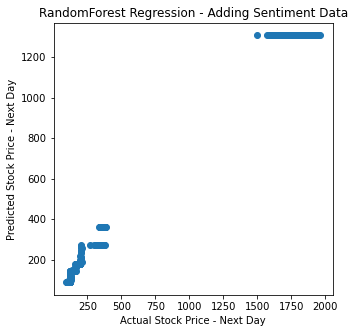

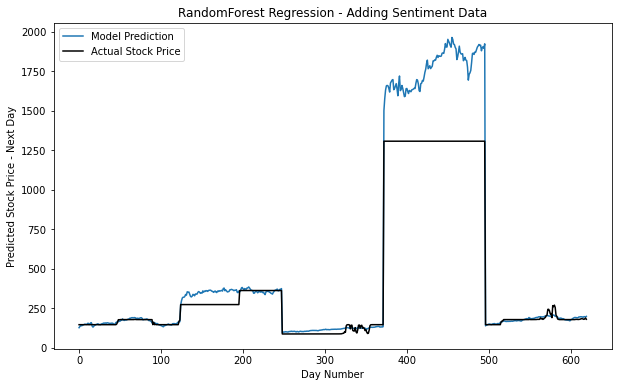

In [737]:
#df = df_base
#df = df_with_fin
df = df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

# remove unnecessary columns
train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]

# Instantiate a random forests regressor 'rf' 
rf = RandomForestRegressor(n_estimators=500,min_samples_leaf=0.1,random_state=3)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)
y_pred_train=rf.predict(X_train)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
print('Train set RMSE of RandomForest: {:.4f}'.format(rmse_train))
print("\nTrain set r^2 score: {:.4f}".format(r2_score(y_train, y_pred_train)))

# rmse for CV dataset
y_pred_cv=rf.predict(X_cv)
y_pred_rf = y_pred_cv
rmse_cv = MSE(y_cv, y_pred_cv)**(1/2)
print('\nValidation set RMSE of RandomForest: {:.4f}'.format(rmse_cv))
print("\nValidation set r^2 score: {:.4f}".format(r2_score(y_cv, y_pred_cv)))


# # Predict the test set labels 'y_pred'
# y_pred = rf.predict(X_test)
# # Evaluate the test set RMSE
# rmse_test = MSE(y_test, y_pred)**(1/2)
# # Print the test set RMSE
# print('Test set RMSE of RandomForest: {:.4f}'.format(rmse_test))

# Compute the array containing the 20-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, X_cv, y_cv, cv=20, scoring='neg_mean_squared_error', n_jobs=-1) 
# Compute the 20-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
# Print RMSE_CV
print('\n20-fold CV RMSE of RandomForest: {:.4f}'.format(RMSE_CV))

## Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_cv, y_pred_cv)
plt.xlabel('Actual Stock Price - Next Day')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('RandomForest Regression - Adding Sentiment Data')
plt.show()

X = [x for x in range(len(y_cv))]
plt.figure(figsize=(10,6))
plt.plot(X,y_cv)
plt.plot(X,y_pred_cv,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('RandomForest Regression - Adding Sentiment Data')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

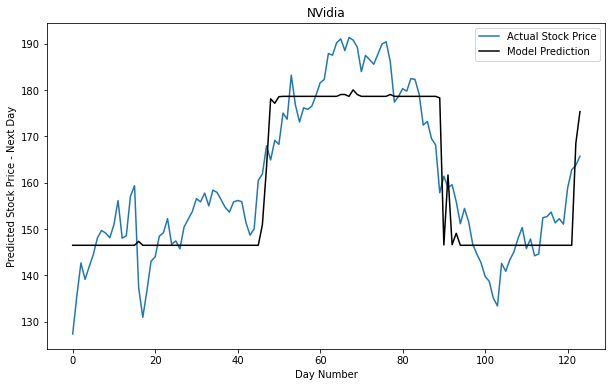

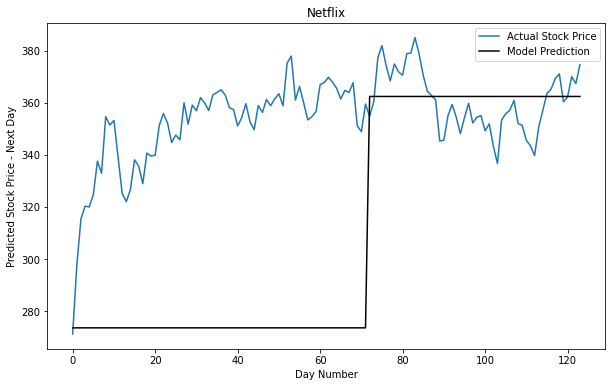

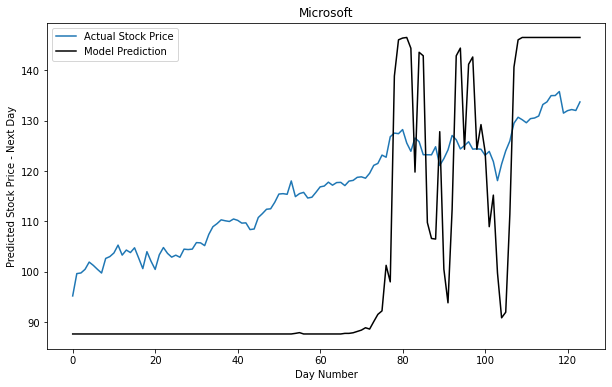

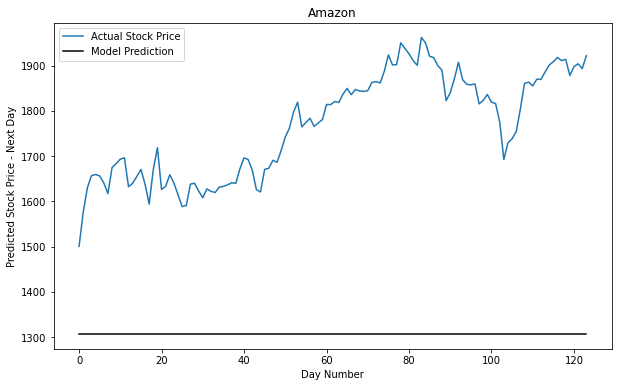

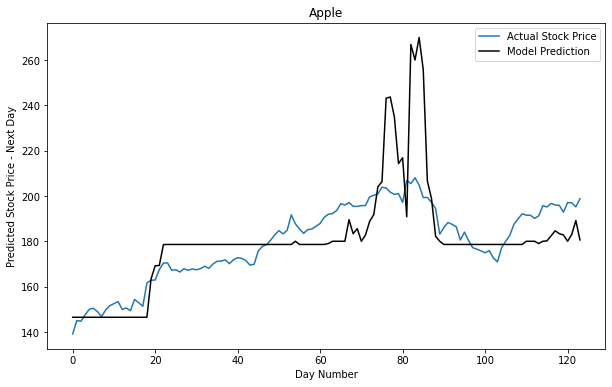

In [738]:
#X_cv[0:124]          NVDA
#X_cv[124:248]       NFLX
#X_cv[248:372]      MSFT
#X_cv[372:496]       AMZN
#X_cv[496:]       AAPL

X = [x for x in range(len(y_cv[0:124]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[0:124])
plt.plot(X,y_pred_cv[0:124],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('NVidia')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[124:248]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[124:248])
plt.plot(X,y_pred_cv[124:248],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Netflix')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[248:372]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[248:372])
plt.plot(X,y_pred_cv[248:372],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Microsoft')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()


#########

X = [x for x in range(len(y_cv[372:496]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[372:496])
plt.plot(X,y_pred_cv[372:496],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Amazon')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[496:]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[496:])
plt.plot(X,y_pred_cv[496:],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Apple')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

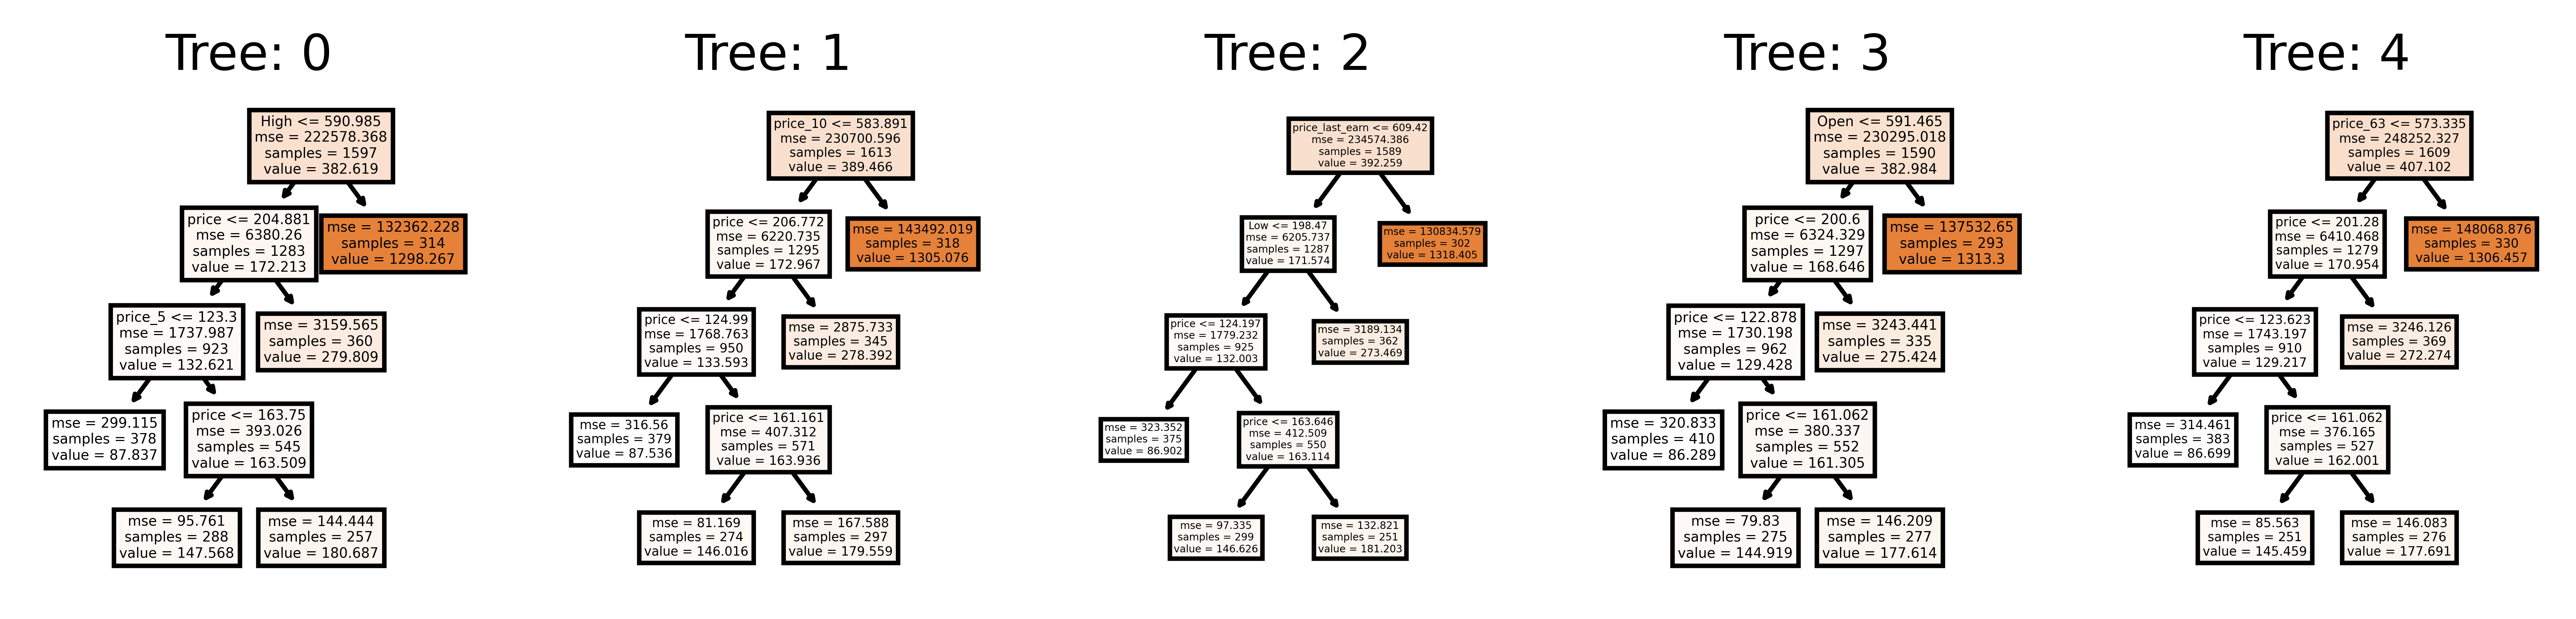

In [678]:
from sklearn.tree import export_graphviz


# This may not the best way to view each estimator as it is small
fn=X_train.columns
cn=y_train.columns

fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rf.estimators_[index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Tree: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

### VIEWING IMPORTANCE OF ALL FEATURES USING RANDOM FOREST REGRESSION

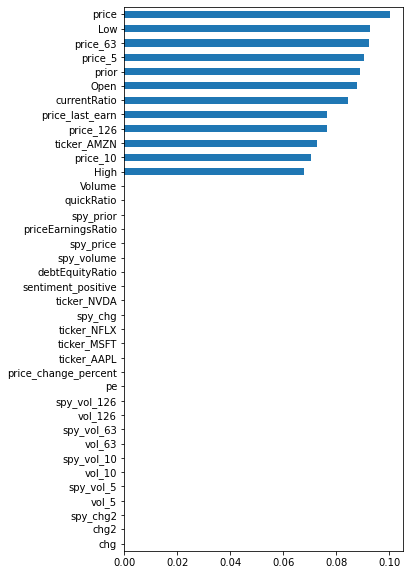

In [679]:
x = X_train
y = y_train

# Create a pd.Series of features importances
plt.figure(figsize=(5,10))
importances_rf = pd.Series(rf.feature_importances_,
index = x.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh')
plt.show()

In [680]:
importances_rf

price                   0.100122
High                    0.067730
Low                     0.092834
Open                    0.087624
Volume                  0.000000
currentRatio            0.084302
quickRatio              0.000000
debtEquityRatio         0.000000
priceEarningsRatio      0.000000
price_last_earn         0.076465
spy_price               0.000000
spy_volume              0.000000
price_5                 0.090395
price_10                0.070597
price_63                0.092168
price_126               0.076451
prior                   0.088767
spy_prior               0.000000
chg                     0.000000
spy_chg                 0.000000
chg2                    0.000000
spy_chg2                0.000000
vol_5                   0.000000
spy_vol_5               0.000000
vol_10                  0.000000
spy_vol_10              0.000000
vol_63                  0.000000
spy_vol_63              0.000000
vol_126                 0.000000
spy_vol_126             0.000000
pe        

# APPLYING GRADIENT BOOSTING REGRESSION

## Baseline

Train set RMSE of GradientBoost: 5.3063

r^2 score: 0.9999

Validation set RMSE of GradientBoost: 16.5076

Validation set r^2 score: 0.9993

CV RMSE of GradientBoost: 19.5269


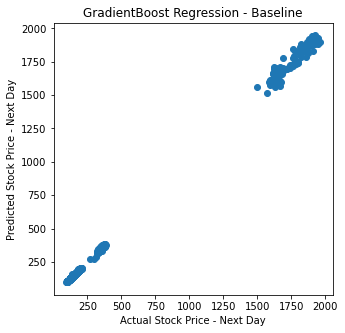

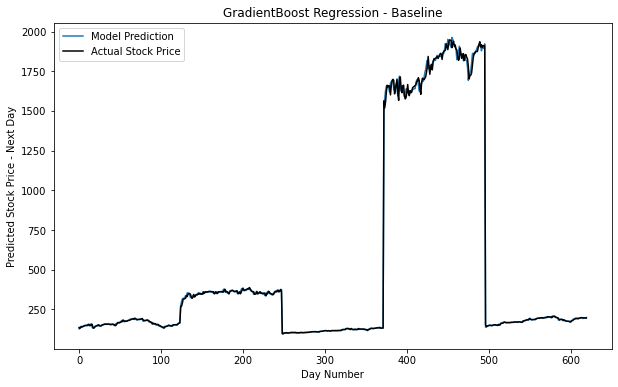

In [739]:
df = df_base
# df = df_with_fin
# df = df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

# remove unnecessary columns
train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]

# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE

# Instantiate Gradient Boosting
gb = GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=3)
# Fit Gradient Boosting to the training set
gb.fit(X_train, y_train)
# Predict the labels of the training set
y_pred_train = gb.predict(X_train)
# Evaluate the training set RMSE of Gradient Boosting
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)
# Print RMSE_train
print('Train set RMSE of GradientBoost: {:.4f}'.format(RMSE_train))
print("\nr^2 score: {:.4f}".format(r2_score(y_train, y_pred_train)))

# rmse for CV dataset
y_pred_cv=gb.predict(X_cv)
rmse_cv = MSE(y_cv, y_pred_cv)**(1/2)
print('\nValidation set RMSE of GradientBoost: {:.4f}'.format(rmse_cv))
print("\nValidation set r^2 score: {:.4f}".format(r2_score(y_cv, y_pred_cv)))


# # Predict test set labels
# y_pred_Gboost = gb.predict(X_test)
# # Compute RMSE
# rmse_test = (MSE(y_test, y_pred_Gboost))**(1/2)
# # Print RMSE
# print("Test set RMSE of GradientBoost: {:.4f}".format(rmse_test))

# Compute the array containing the 20-folds CV MSEs
MSE_CV_scores = - cross_val_score(gb, X_cv, y_cv, cv=20, scoring='neg_mean_squared_error', n_jobs=-1) 
# Compute the 20-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
# Print RMSE_CV
print('\nCV RMSE of GradientBoost: {:.4f}'.format(RMSE_CV))


## Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_cv, y_pred_cv)
plt.xlabel('Actual Stock Price - Next Day')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('GradientBoost Regression - Baseline')
plt.show()

X = [x for x in range(len(y_cv))]
plt.figure(figsize=(10,6))
plt.plot(X,y_cv)
plt.plot(X,y_pred_cv,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('GradientBoost Regression - Baseline')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

### Adding Financial Features

Train set RMSE of GradientBoost: 1.0201

r^2 score: 1.0000

Validation set RMSE of GradientBoost: 22.3759

Validation set r^2 score: 0.9988

CV RMSE of GradientBoost: 18.3436


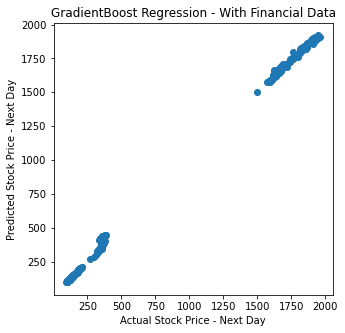

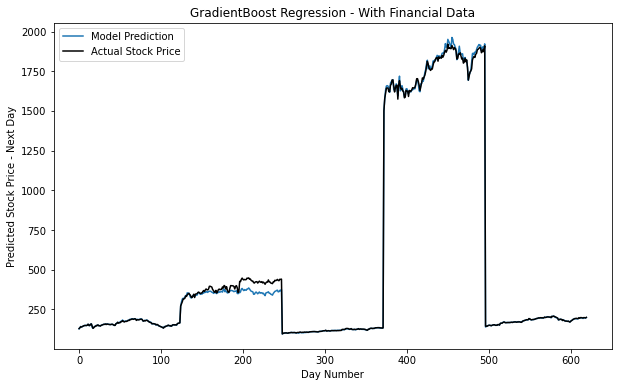

In [741]:
#df = df_base
df = df_with_fin
# df = df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

# remove unnecessary columns
train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]

# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE

# Instantiate Gradient Boosting
gb = GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=3)
# Fit Gradient Boosting to the training set
gb.fit(X_train, y_train)
# Predict the labels of the training set
y_pred_train = gb.predict(X_train)
# Evaluate the training set RMSE of Gradient Boosting
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)
# Print RMSE_train
print('Train set RMSE of GradientBoost: {:.4f}'.format(RMSE_train))
print("\nr^2 score: {:.4f}".format(r2_score(y_train, y_pred_train)))

# rmse for CV dataset
y_pred_cv=gb.predict(X_cv)
rmse_cv = MSE(y_cv, y_pred_cv)**(1/2)
print('\nValidation set RMSE of GradientBoost: {:.4f}'.format(rmse_cv))
print("\nValidation set r^2 score: {:.4f}".format(r2_score(y_cv, y_pred_cv)))


# # Predict test set labels
# y_pred_Gboost = gb.predict(X_test)
# # Compute RMSE
# rmse_test = (MSE(y_test, y_pred_Gboost))**(1/2)
# # Print RMSE
# print("Test set RMSE of GradientBoost: {:.4f}".format(rmse_test))

# Compute the array containing the 20-folds CV MSEs
MSE_CV_scores = - cross_val_score(gb, X_cv, y_cv, cv=20, scoring='neg_mean_squared_error', n_jobs=-1) 
# Compute the 20-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
# Print RMSE_CV
print('\nCV RMSE of GradientBoost: {:.4f}'.format(RMSE_CV))


## Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_cv, y_pred_cv)
plt.xlabel('Actual Stock Price - Next Day')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('GradientBoost Regression - With Financial Data')
plt.show()

X = [x for x in range(len(y_cv))]
plt.figure(figsize=(10,6))
plt.plot(X,y_cv)
plt.plot(X,y_pred_cv,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('GradientBoost Regression - With Financial Data')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

# Added Sentiment Data:

Train set RMSE of GradientBoost: 1.0335

r^2 score: 1.0000

Validation set RMSE of GradientBoost: 13.5324

Validation set r^2 score: 0.9995

CV RMSE of GradientBoost: 17.5256


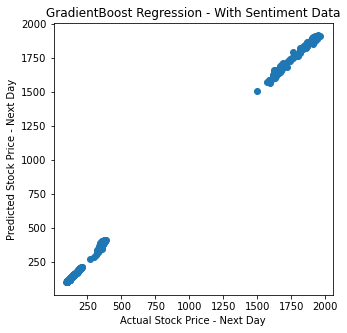

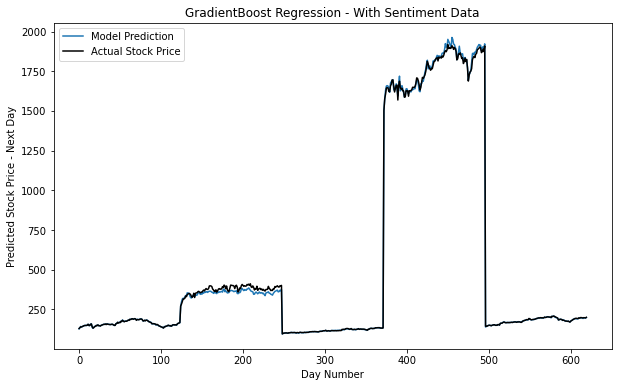

In [742]:
#df = df_base
#df = df_with_fin
df = df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

# remove unnecessary columns
train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]

# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE

# Instantiate Gradient Boosting
gb = GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=3)
# Fit Gradient Boosting to the training set
gb.fit(X_train, y_train)
# Predict the labels of the training set
y_pred_train = gb.predict(X_train)
# Evaluate the training set RMSE of Gradient Boosting
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)
# Print RMSE_train
print('Train set RMSE of GradientBoost: {:.4f}'.format(RMSE_train))
print("\nr^2 score: {:.4f}".format(r2_score(y_train, y_pred_train)))

# rmse for CV dataset
y_pred_cv=gb.predict(X_cv)
y_pred_gb = y_pred_cv
rmse_cv = MSE(y_cv, y_pred_cv)**(1/2)
print('\nValidation set RMSE of GradientBoost: {:.4f}'.format(rmse_cv))
print("\nValidation set r^2 score: {:.4f}".format(r2_score(y_cv, y_pred_cv)))


# # Predict test set labels
# y_pred_Gboost = gb.predict(X_test)
# # Compute RMSE
# rmse_test = (MSE(y_test, y_pred_Gboost))**(1/2)
# # Print RMSE
# print("Test set RMSE of GradientBoost: {:.4f}".format(rmse_test))

# Compute the array containing the 20-folds CV MSEs
MSE_CV_scores = - cross_val_score(gb, X_cv, y_cv, cv=20, scoring='neg_mean_squared_error', n_jobs=-1) 
# Compute the 20-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
# Print RMSE_CV
print('\nCV RMSE of GradientBoost: {:.4f}'.format(RMSE_CV))


## Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_cv, y_pred_cv)
plt.xlabel('Actual Stock Price - Next Day')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('GradientBoost Regression - With Sentiment Data')
plt.show()

X = [x for x in range(len(y_cv))]
plt.figure(figsize=(10,6))
plt.plot(X,y_cv)
plt.plot(X,y_pred_cv,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('GradientBoost Regression - With Sentiment Data')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

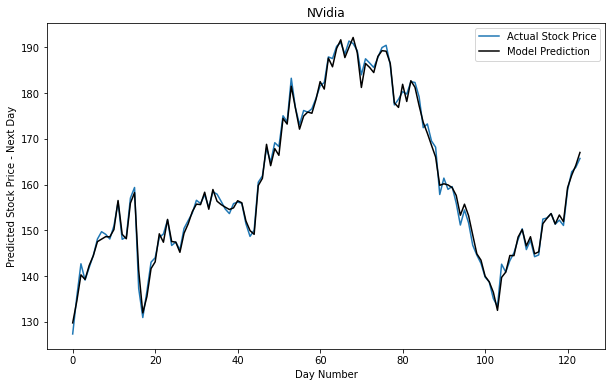

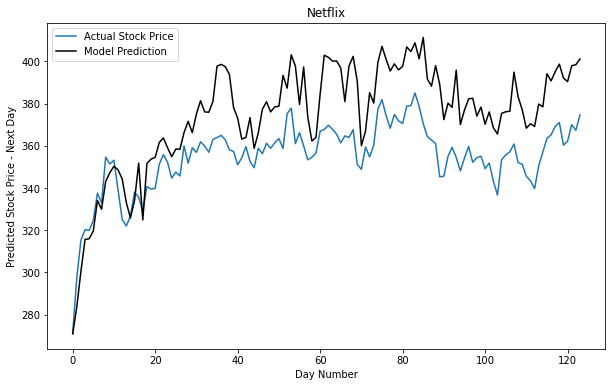

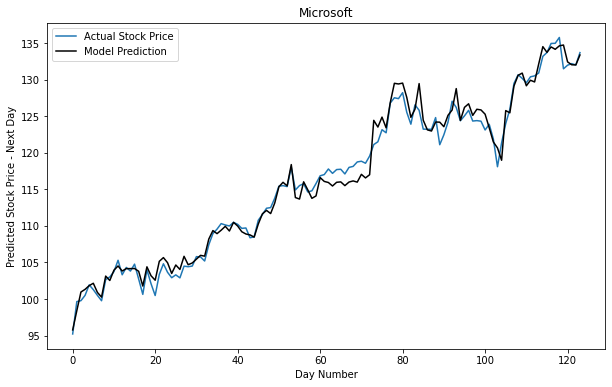

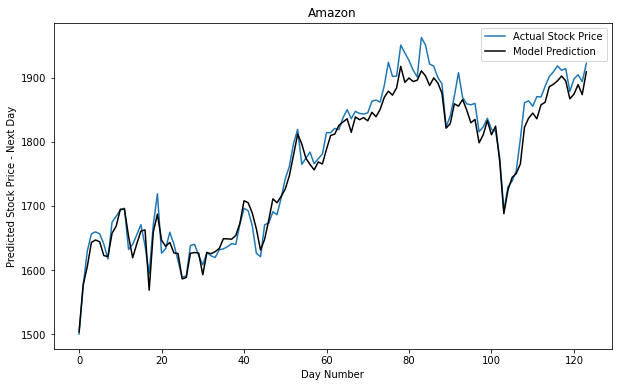

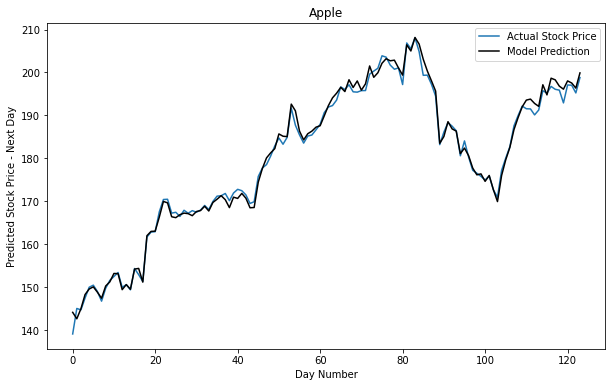

In [743]:
#X_cv[0:124]          NVDA
#X_cv[124:248]       NFLX
#X_cv[248:372]      MSFT
#X_cv[372:496]       AMZN
#X_cv[496:]       AAPL

X = [x for x in range(len(y_cv[0:124]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[0:124])
plt.plot(X,y_pred_cv[0:124],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('NVidia')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[124:248]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[124:248])
plt.plot(X,y_pred_cv[124:248],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Netflix')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[248:372]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[248:372])
plt.plot(X,y_pred_cv[248:372],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Microsoft')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()


#########

X = [x for x in range(len(y_cv[372:496]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[372:496])
plt.plot(X,y_pred_cv[372:496],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Amazon')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[496:]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[496:])
plt.plot(X,y_pred_cv[496:],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Apple')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

# APPLYING SUPPORT VECTOR REGRESSION

## Baseline

Train set RMSE of SVR: 325.3742

r^2 score: 0.5574

Validation set RMSE of SVR: 498.9265

Validation set r^2 score: 0.3801

CV RMSE of SVR: 646.8487


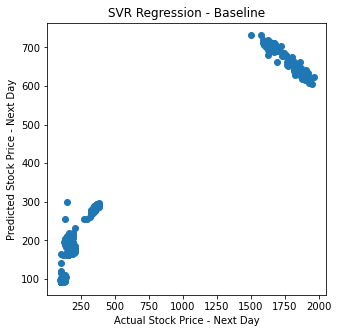

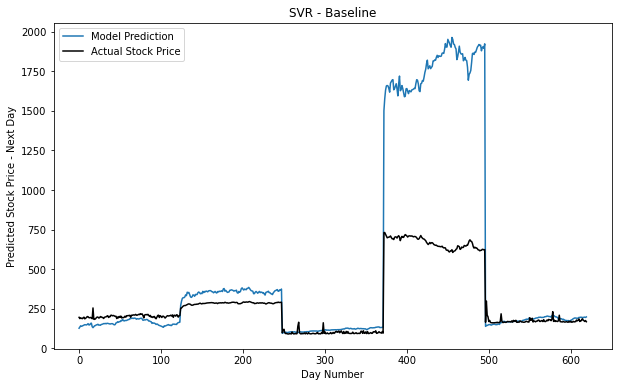

In [744]:
df = df_base
# df = df_with_fin
# df = df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

# remove unnecessary columns
train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]


from sklearn.svm import SVR

#df_x = df.drop(['price'], axis=1)
#df_y = df[['price']]
#y = df_y.values.ravel()
#x = df_x.values

# Split dataset into 80% train and 20% test
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.1))
regr.fit(X_train, y_train)
y_pred_train=regr.predict(X_train)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the train set RMSE
print('Train set RMSE of SVR: {:.4f}'.format(rmse_train))
print("\nr^2 score: {:.4f}".format(r2_score(y_train, y_pred_train)))


# rmse for CV dataset
y_pred_cv=regr.predict(X_cv)
rmse_cv = MSE(y_cv, y_pred_cv)**(1/2)
print('\nValidation set RMSE of SVR: {:.4f}'.format(rmse_cv))
print("\nValidation set r^2 score: {:.4f}".format(r2_score(y_cv, y_pred_cv)))


# # Predict the test set labels 'y_pred'
# y_pred = regr.predict(X_test)
# # Evaluate the test set RMSE
# rmse_test = MSE(y_test, y_pred)**(1/2)
# # Print the test set RMSE
# print('Test set RMSE of SVR: {:.4f}'.format(rmse_test))


# Compute the array containing the 20-folds CV MSEs
MSE_CV_scores = - cross_val_score(regr, X_cv, y_cv, cv=20, scoring='neg_mean_squared_error', n_jobs=-1) 
# Compute the 20-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
# Print RMSE_CV
print('\nCV RMSE of SVR: {:.4f}'.format(RMSE_CV))

## Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_cv, y_pred_cv)
plt.xlabel('Actual Stock Price - Next Day')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('SVR Regression - Baseline')
plt.show()

X = [x for x in range(len(y_cv))]
plt.figure(figsize=(10,6))
plt.plot(X,y_cv)
plt.plot(X,y_pred_cv,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('SVR - Baseline')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

## Adding Financial Factors

Train set RMSE of SVR: 394.7875

r^2 score: 0.3484

Validation set RMSE of SVR: 579.1593

Validation set r^2 score: 0.1647

CV RMSE of SVR: 666.4014


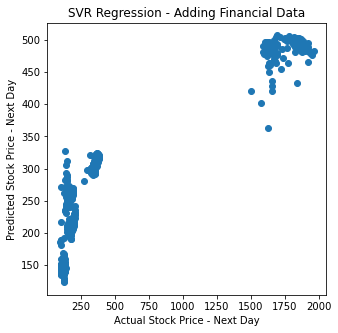

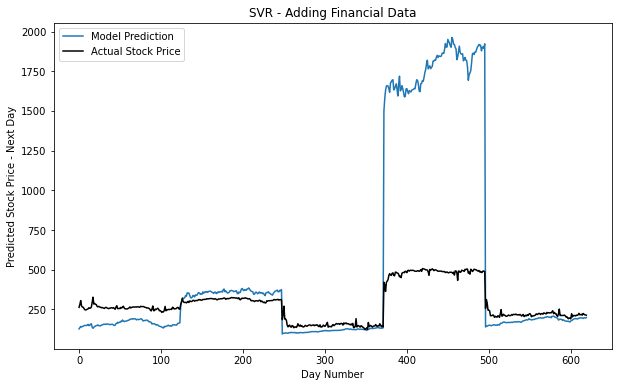

In [746]:
#df = df_base
df = df_with_fin
# df = df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

# remove unnecessary columns
train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]


from sklearn.svm import SVR

#df_x = df.drop(['price'], axis=1)
#df_y = df[['price']]
#y = df_y.values.ravel()
#x = df_x.values

# Split dataset into 80% train and 20% test
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.1))
regr.fit(X_train, y_train)
y_pred_train=regr.predict(X_train)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the train set RMSE
print('Train set RMSE of SVR: {:.4f}'.format(rmse_train))
print("\nr^2 score: {:.4f}".format(r2_score(y_train, y_pred_train)))


# rmse for CV dataset
y_pred_cv=regr.predict(X_cv)
rmse_cv = MSE(y_cv, y_pred_cv)**(1/2)
print('\nValidation set RMSE of SVR: {:.4f}'.format(rmse_cv))
print("\nValidation set r^2 score: {:.4f}".format(r2_score(y_cv, y_pred_cv)))


# # Predict the test set labels 'y_pred'
# y_pred = regr.predict(X_test)
# # Evaluate the test set RMSE
# rmse_test = MSE(y_test, y_pred)**(1/2)
# # Print the test set RMSE
# print('Test set RMSE of SVR: {:.4f}'.format(rmse_test))


# Compute the array containing the 20-folds CV MSEs
MSE_CV_scores = - cross_val_score(regr, X_cv, y_cv, cv=20, scoring='neg_mean_squared_error', n_jobs=-1) 
# Compute the 20-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
# Print RMSE_CV
print('\nCV RMSE of SVR: {:.4f}'.format(RMSE_CV))

## Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_cv, y_pred_cv)
plt.xlabel('Actual Stock Price - Next Day')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('SVR Regression - Adding Financial Data')
plt.show()

X = [x for x in range(len(y_cv))]
plt.figure(figsize=(10,6))
plt.plot(X,y_cv)
plt.plot(X,y_pred_cv,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('SVR - Adding Financial Data')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

## Adding Sentiment Data

Train set RMSE of SVR: 421.4603

r^2 score: 0.2574

Validation set RMSE of SVR: 605.2405

Validation set r^2 score: 0.0878

CV RMSE of SVR: 675.2992


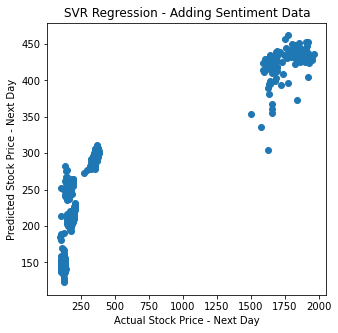

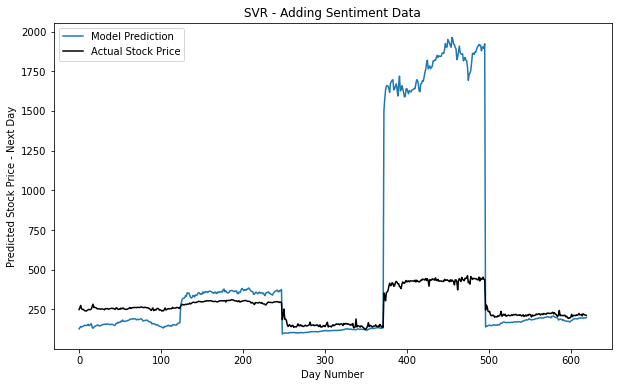

In [747]:
#df = df_base
# df = df_with_fin
df = df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

# remove unnecessary columns
train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]


from sklearn.svm import SVR

#df_x = df.drop(['price'], axis=1)
#df_y = df[['price']]
#y = df_y.values.ravel()
#x = df_x.values

# Split dataset into 80% train and 20% test
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.1))
regr.fit(X_train, y_train)
y_pred_train=regr.predict(X_train)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the train set RMSE
print('Train set RMSE of SVR: {:.4f}'.format(rmse_train))
print("\nr^2 score: {:.4f}".format(r2_score(y_train, y_pred_train)))


# rmse for CV dataset
y_pred_cv=regr.predict(X_cv)
y_pred_svr = y_pred_cv
rmse_cv = MSE(y_cv, y_pred_cv)**(1/2)
print('\nValidation set RMSE of SVR: {:.4f}'.format(rmse_cv))
print("\nValidation set r^2 score: {:.4f}".format(r2_score(y_cv, y_pred_cv)))


# # Predict the test set labels 'y_pred'
# y_pred = regr.predict(X_test)
# # Evaluate the test set RMSE
# rmse_test = MSE(y_test, y_pred)**(1/2)
# # Print the test set RMSE
# print('Test set RMSE of SVR: {:.4f}'.format(rmse_test))


# Compute the array containing the 20-folds CV MSEs
MSE_CV_scores = - cross_val_score(regr, X_cv, y_cv, cv=20, scoring='neg_mean_squared_error', n_jobs=-1) 
# Compute the 20-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)
# Print RMSE_CV
print('\nCV RMSE of SVR: {:.4f}'.format(RMSE_CV))

## Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_cv, y_pred_cv)
plt.xlabel('Actual Stock Price - Next Day')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('SVR Regression - Adding Sentiment Data')
plt.show()

X = [x for x in range(len(y_cv))]
plt.figure(figsize=(10,6))
plt.plot(X,y_cv)
plt.plot(X,y_pred_cv,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('SVR - Adding Sentiment Data')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

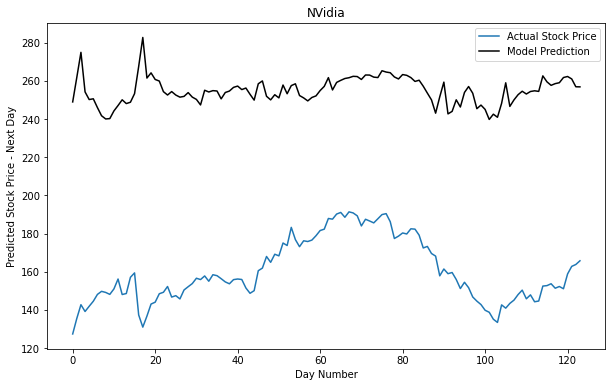

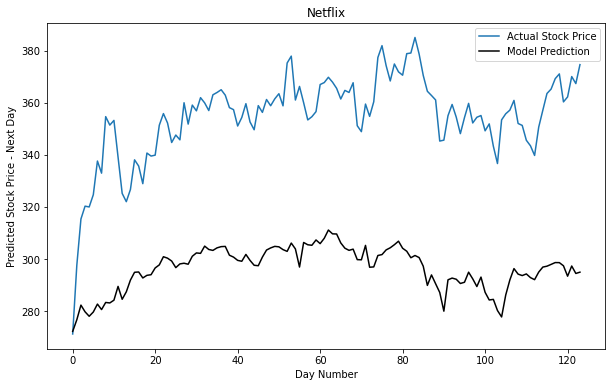

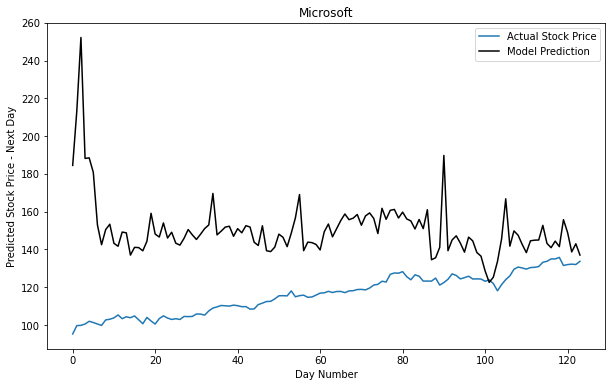

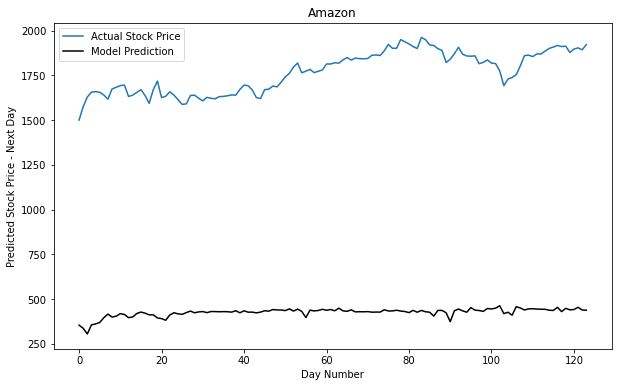

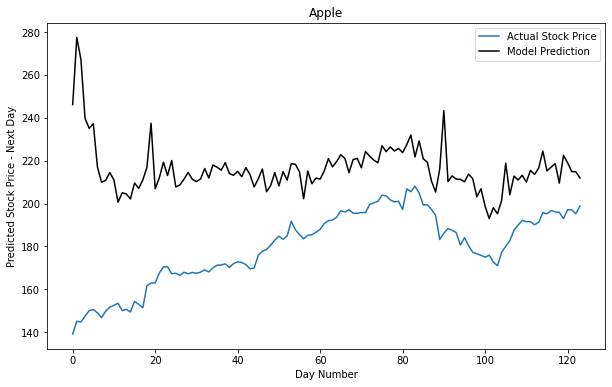

In [748]:
#X_cv[0:124]          NVDA
#X_cv[124:248]       NFLX
#X_cv[248:372]      MSFT
#X_cv[372:496]       AMZN
#X_cv[496:]       AAPL

X = [x for x in range(len(y_cv[0:124]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[0:124])
plt.plot(X,y_pred_cv[0:124],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('NVidia')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[124:248]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[124:248])
plt.plot(X,y_pred_cv[124:248],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Netflix')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[248:372]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[248:372])
plt.plot(X,y_pred_cv[248:372],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Microsoft')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()


#########

X = [x for x in range(len(y_cv[372:496]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[372:496])
plt.plot(X,y_pred_cv[372:496],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Amazon')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[496:]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[496:])
plt.plot(X,y_pred_cv[496:],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Apple')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

# Model Comparison

In [ ]:
#X_cv[0:124]          NVDA
#X_cv[124:248]       NFLX
#X_cv[248:372]      MSFT
#X_cv[372:496]       AMZN
#X_cv[496:]       AAPL

X = [x for x in range(len(y_cv[0:124]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[0:124])
plt.plot(X,y_pred_cv[0:124],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('NVidia')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[124:248]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[124:248])
plt.plot(X,y_pred_cv[124:248],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Netflix')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[248:372]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[248:372])
plt.plot(X,y_pred_cv[248:372],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Microsoft')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()


#########

X = [x for x in range(len(y_cv[372:496]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[372:496])
plt.plot(X,y_pred_cv[372:496],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Amazon')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#########

X = [x for x in range(len(y_cv[496:]))]

plt.figure(figsize=(10,6))
plt.plot(X,y_cv[496:])
plt.plot(X,y_pred_cv[496:],color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Apple')
plt.legend(["Actual Stock Price","Model Prediction"])
plt.show()

#X_cv[0:124]          NVDA
#X_cv[124:248]       NFLX
#X_cv[248:372]      MSFT
#X_cv[372:496]       AMZN
#X_cv[496:]       AAPL

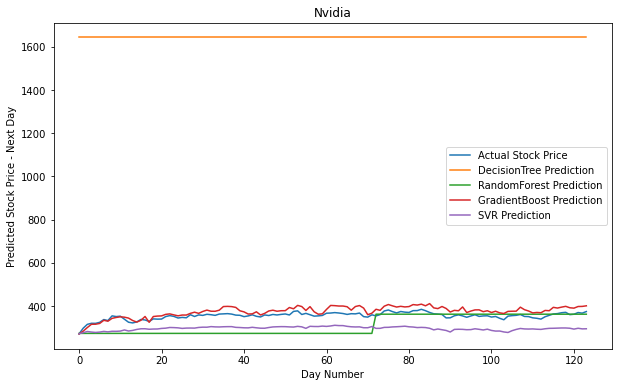

In [753]:
X = [x for x in range(len(y_cv[124:248]))]
plt.figure(figsize=(10,6))
plt.plot(X,y_cv[124:248])
plt.plot(X,y_pred_dt[124:248])
plt.plot(X,y_pred_rf[124:248])
plt.plot(X,y_pred_gb[124:248])
plt.plot(X,y_pred_svr[124:248])

plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Nvidia')
plt.legend(["Actual Stock Price","DecisionTree Prediction","RandomForest Prediction","GradientBoost Prediction",
            "SVR Prediction"])
plt.show()

# Selected Model: Gradient Boosting

In [472]:
#df = df_base
#df = df_with_fin
df = df_with_sentiment

train = df[df['IS']==1].copy()
cv = df[df['CV']==1].copy()
test = df[(df['CV']==0)&(df['IS']==0)].copy()

# remove unnecessary columns
train=train.drop(['IS','CV'], axis=1)
train=train.reset_index(drop=True)
X_train = train.drop(['next_day_price','Date'], axis=1)
y_train = train[['next_day_price']]

test=test.drop(['IS','CV'], axis=1)
test=test.reset_index(drop=True)
X_test = test.drop(['next_day_price','Date'], axis=1)
y_test = test[['next_day_price']]

cv=cv.drop(['IS','CV'], axis=1)
cv=cv.reset_index(drop=True)
X_cv = cv.drop(['next_day_price','Date'], axis=1)
y_cv = cv[['next_day_price']]

In [475]:
# # Predict test set labels
y_pred_Gboost = gb.predict(X_test)
# # Compute RMSE
rmse_test = (MSE(y_test, y_pred_Gboost))**(1/2)
# # Print RMSE
#print("Test set RMSE of GradientBoost: {:.4f}".format(rmse_test))

# R^2 (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, 
# would get a R^2 score of 0.0.

print("\nTest Set RMSE score: ",mean_squared_error(y_test, y_pred_Gboost, squared=False))
print("\nr^2 score: ",r2_score(y_test, y_pred_Gboost))

test['y_pred_Gboost'] = y_pred_Gboost


Test Set RMSE score:  48.33437201389779

r^2 score:  0.994327688979078


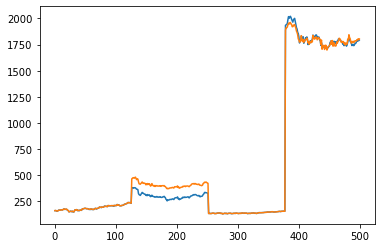

In [477]:
# ## Scatterplot
# plt.figure(figsize=(5,5))
# plt.scatter(test["next_day_price"], test["y_pred_Gboost"])


# plt.show()

import matplotlib.pyplot as plt

plt.plot(test["next_day_price"][:500])
plt.plot(test["y_pred_Gboost"][:500])
plt.show()


## All stocks combined

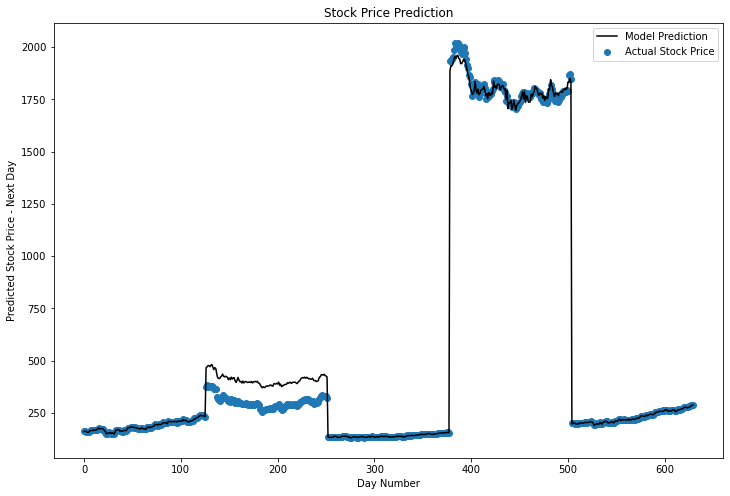

In [485]:
#test_apple = test[test["ticker_AAPL"]==1]

X = [x for x in range(len(test))]
ylab = test['y_pred_Gboost']
actual = test["next_day_price"]

plt.figure(figsize=(12,8))
plt.scatter(X,actual)
plt.plot(X,ylab,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Stock Price Prediction')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

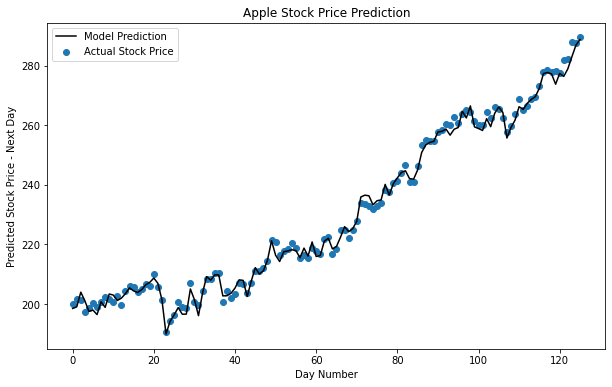

In [481]:
test_apple = test[test["ticker_AAPL"]==1]

X = [x for x in range(len(test_apple))]
ylab = test_apple['y_pred_Gboost']
actual = test_apple["next_day_price"]

plt.figure(figsize=(10,6))
plt.scatter(X,actual)
plt.plot(X,ylab,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Apple Stock Price Prediction')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()


 AAPL RMSE score:  1.8397190038456215

 AAPL r^2 score:  0.995658298799097


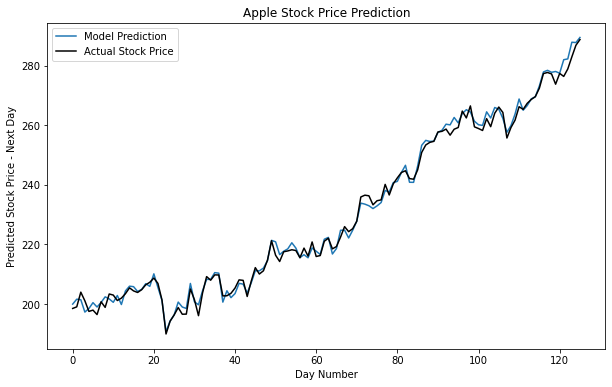

In [495]:
test_apple = test[test["ticker_AAPL"]==1]

print("\n AAPL RMSE score: ",mean_squared_error(test_apple["next_day_price"], test_apple["y_pred_Gboost"], squared=False))
print("\n AAPL r^2 score: ",r2_score(test_apple["next_day_price"], test_apple["y_pred_Gboost"]))

# plotting the apple output
X = [x for x in range(len(test_apple))]
ylab = test_apple['y_pred_Gboost']
actual = test_apple["next_day_price"]

plt.figure(figsize=(10,6))
plt.plot(X,actual)
plt.plot(X,ylab,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Apple Stock Price Prediction')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()


 AMZN RMSE score:  25.577784205944717

 AMZN r^2 score:  0.8945805607026631


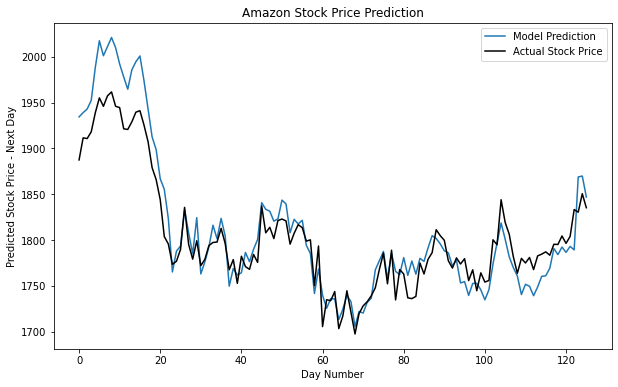

In [493]:
test_AMZN = test[test["ticker_AMZN"]==1]

print("\n AMZN RMSE score: ",mean_squared_error(test_AMZN["next_day_price"], test_AMZN["y_pred_Gboost"], squared=False))
print("\n AMZN r^2 score: ",r2_score(test_AMZN["next_day_price"], test_AMZN["y_pred_Gboost"]))

# plotting the apple output
X = [x for x in range(len(test_AMZN))]
ylab = test_AMZN['y_pred_Gboost']
actual = test_AMZN["next_day_price"]

plt.figure(figsize=(10,6))
plt.plot(X,actual)
plt.plot(X,ylab,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Amazon Stock Price Prediction')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()


 MSFT RMSE score:  1.0613490907631011

 MSFT r^2 score:  0.9767610054284404


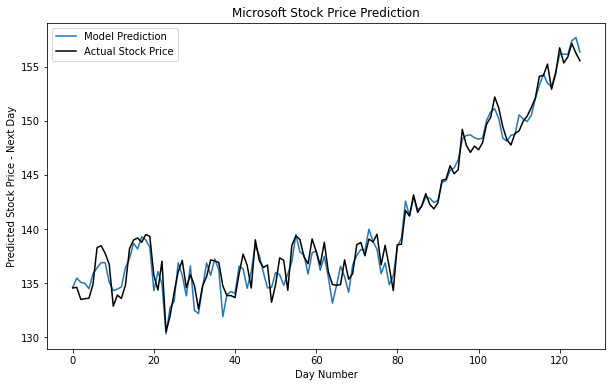

In [496]:
test_MSFT = test[test["ticker_MSFT"]==1]

print("\n MSFT RMSE score: ",mean_squared_error(test_MSFT["next_day_price"], test_MSFT["y_pred_Gboost"], squared=False))
print("\n MSFT r^2 score: ",r2_score(test_MSFT["next_day_price"], test_MSFT["y_pred_Gboost"]))

# plotting the apple output
X = [x for x in range(len(test_MSFT))]
ylab = test_MSFT['y_pred_Gboost']
actual = test_MSFT["next_day_price"]

plt.figure(figsize=(10,6))
plt.plot(X,actual)
plt.plot(X,ylab,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Microsoft Stock Price Prediction')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()


 NFLX RMSE score:  104.9776890568123

 NFLX r^2 score:  -12.751207181588153


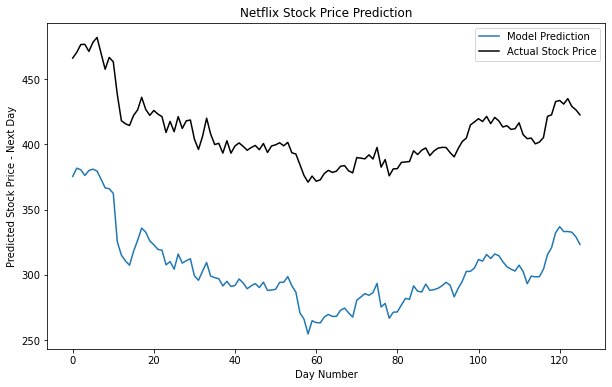

In [499]:
test_NFLX = test[test["ticker_NFLX"]==1]

print("\n NFLX RMSE score: ",mean_squared_error(test_NFLX["next_day_price"], test_NFLX["y_pred_Gboost"], squared=False))
print("\n NFLX r^2 score: ",r2_score(test_NFLX["next_day_price"], test_NFLX["y_pred_Gboost"]))

# plotting the apple output
X = [x for x in range(len(test_NFLX))]
ylab = test_NFLX['y_pred_Gboost']
actual = test_NFLX["next_day_price"]

plt.figure(figsize=(10,6))
plt.plot(X,actual)
plt.plot(X,ylab,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Netflix Stock Price Prediction')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()


 NVDA RMSE score:  1.4171511525279328

 NVDA r^2 score:  0.9964844471044897


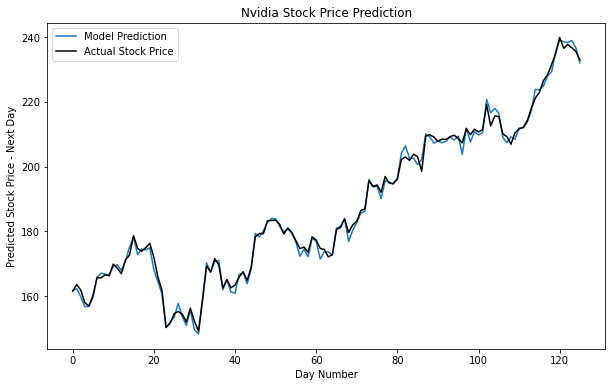

In [500]:
test_NVDA = test[test["ticker_NVDA"]==1]

print("\n NVDA RMSE score: ",mean_squared_error(test_NVDA["next_day_price"], test_NVDA["y_pred_Gboost"], squared=False))
print("\n NVDA r^2 score: ",r2_score(test_NVDA["next_day_price"], test_NVDA["y_pred_Gboost"]))

# plotting the apple output
X = [x for x in range(len(test_NVDA))]
ylab = test_NVDA['y_pred_Gboost']
actual = test_NVDA["next_day_price"]

plt.figure(figsize=(10,6))
plt.plot(X,actual)
plt.plot(X,ylab,color="black")
plt.xlabel('Day Number')
plt.ylabel('Predicted Stock Price - Next Day')
plt.title('Nvidia Stock Price Prediction')
plt.legend(["Model Prediction","Actual Stock Price"])
plt.show()

# Appendix

In [93]:
ratings = pd.read_csv("ratings.csv",encoding='latin1')
ratings.drop(["Score","retweets","id"],axis=1,inplace=True)
ratings["ticker"] = "NFLX"

In [94]:
ratings

date                                               text ticker
0     1/1/17  $ NFLX maturity 01/06/2017 Vol PutCallRatio of...   NFLX
1     1/1/17  2017 Top Picks: Tesla (TSLA), Netflix(NFLX), a...   NFLX
2     1/2/17  Just finished # TheOA Highly recommend it. Bra...   NFLX
3     1/2/17  Breaks the 122 level and we c\u2026 $ NFLX htt...   NFLX
4     1/2/17  Wall Street's Top Picks For 2017: All In One P...   NFLX
..       ...                                                ...    ...
995  5/16/17  Netflix or Twitter; Which One Should You Buy S...   NFLX
996  5/16/17  # Forex Netflix fails to hold gains - Analysis...   NFLX
997  5/16/17  Dobbs: My greatest regret is being paid in cas...   NFLX
998  5/16/17  music Netflix Flashed Warnings Before The Stoc...   NFLX
999  5/16/17  Yeah they always add things that are garbage, ...   NFLX

[1000 rows x 3 columns]

In [100]:
import FundamentalAnalysis as fa
# The ratios could only be retrived for one company at a time using the free API Key from FinancialModellingPrep
# AAPL_ratio =  fa.financial_ratios('AAPL', "b1954571c728b215d6fe4e5a75f51636", period="quarter")
NFLX_ratio =  fa.financial_ratios('NFLX', "6074ce367d456018f7d624e2c930f082", period="quarter")
# AMZN_ratio =  fa.financial_ratios('AMZN', "b1954571c728b215d6fe4e5a75f51636", period="quarter")
# MSFT_ratio =  fa.financial_ratios('MSFT', "b1954571c728b215d6fe4e5a75f51636", period="quarter")
# NVDA_ratio =  fa.financial_ratios('NVDA', "b1954571c728b215d6fe4e5a75f51636", period="quarter")

# Save the quarterly ratios from 2015Q4 to 2019Q4 for further analysis
# AAPLratio_4Y = AAPL_ratio.T.iloc[2:19]
NFLXratio_4Y = NFLX_ratio.T.iloc[2:19]
# AMZNratio_4Y = AMZN_ratio.T.iloc[2:19]
# MSFTratio_4Y = MSFT_ratio.T.iloc[2:19]
# NVDAratio_4Y = NVDA_ratio.T.iloc[2:19]

NFLXratio_4Y.head(7)

currentRatio  quickRatio  cashRatio  daysOfSalesOutstanding  \
2019-12      0.901222    0.798290   0.732010               30.335187   
2019-09      0.734063    0.675290   0.611061               32.441259   
2019-06      0.847587    0.721699   0.721699                0.000000   
2019-03      0.607907    0.488284   0.488284                0.000000   
2018-12      1.494320    1.378947   0.584908              449.069571   
2018-09      1.386154    1.279136   0.487139              455.223283   
2018-06      1.537336    1.432566   0.642434              448.765132   

         daysOfInventoryOutstanding  operatingCycle  \
2019-12                         0.0       30.335187   
2019-09                         0.0       32.441259   
2019-06                         0.0        0.000000   
2019-03                         0.0        0.000000   
2018-12                         0.0      449.069571   
2018-09                         0.0      455.223283   
2018-06                         0.0      448.765132   

         daysOfPayablesOutstanding  cashConversionCycle  grossProfitMargin  \
2019-12                 535.797489          -505.462302           0.366060   
2019-09                 625.001788          -592.560530           0.409347   
2019-06                 642.453272          -642.453272           0.389481   
2019-03                 674.259637          -674.259637           0.365048   
2018-12                 623.689714          -174.620144           0.266929   
2018-09                 764.710028          -309.486744           0.396810   
2018-06                 795.224682          -346.459550           0.413943   

         operatingProfitMargin  pretaxProfitMargin  netProfitMargin  \
2019-12               0.083862            0.027313         0.107357   
2019-09               0.186894            0.193011         0.126836   
2019-06               0.143490            0.101748         0.054975   
2019-03               0.101545            0.088401         0.076101   
2018-12               0.051535            0.028517         0.031989   
2018-09               0.120193            0.094714         0.100715   
2018-06               0.118291            0.109692         0.098354   

         effectiveTaxRate  returnOnAssets  returnOnEquity  \
2019-12         -2.076587        0.017276        0.077415   
2019-09          0.342854        0.021500        0.096953   
2019-06          0.459690        0.008970        0.044329   
2019-03          0.139136        0.012640        0.060328   
2018-12         -0.194621        0.005156        0.025566   
2018-09          0.035903        0.017239        0.080399   
2018-06          0.103360        0.016956        0.085457   

         returnOnCapitalEmployed  netIncomePerEBT  ebtPerEbit  ebitPerRevenue  \
2019-12                 0.005506         3.930611         1.0        0.027313   
2019-09                 0.042743         0.657146         1.0        0.193011   
2019-06                 0.021556         0.540310         1.0        0.101748   
2019-03                 0.019629         0.860864         1.0        0.088401   
2018-12                 0.006127         1.121763         1.0        0.028517   
2018-09                 0.022194         1.063358         1.0        0.094714   
2018-06                 0.025844         0.896640         1.0        0.109692   

         debtRatio  debtEquityRatio  longTermDebtToCapitalization  \
2019-12   0.776836         3.481009                      0.660623   
2019-09   0.778244         3.509464                      0.644247   
2019-06   0.797637         3.941627                      0.673495   
2019-03   0.790472         3.772638                      0.643739   
2018-12   0.798310         3.958115                      0.664156   
2018-09   0.785629         3.664072                      0.624635   
2018-06   0.801580         4.039804                      0.649739   

         totalDebtToCapitalization  interestCoverage  cashFlowToDebtRatio  \
2019-12                      

In [98]:
NFLXratio_4Y.columns

Index(['currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding',
       'daysOfInventoryOutstanding', 'operatingCycle',
       'daysOfPayablesOutstanding', 'cashConversionCycle', 'grossProfitMargin',
       'operatingProfitMargin', 'pretaxProfitMargin', 'netProfitMargin',
       'effectiveTaxRate', 'returnOnAssets', 'returnOnEquity',
       'returnOnCapitalEmployed', 'netIncomePerEBT', 'ebtPerEbit',
       'ebitPerRevenue', 'debtRatio', 'debtEquityRatio',
       'longTermDebtToCapitalization', 'totalDebtToCapitalization',
       'interestCoverage', 'cashFlowToDebtRatio', 'companyEquityMultiplier',
       'receivablesTurnover', 'payablesTurnover', 'inventoryTurnover',
       'fixedAssetTurnover', 'assetTurnover', 'operatingCashFlowPerShare',
       'freeCashFlowPerShare', 'cashPerShare', 'payoutRatio',
       'operatingCashFlowSalesRatio', 'freeCashFlowOperatingCashFlowRatio',
       'cashFlowCoverageRatios', 'shortTermCoverageRatios',
       'capitalExpenditureCoverageRatio'